In [1]:
import graph_tool as gt
import meshplot as mp

from model import Opt_GMM_Mapper
from model import Trainer
from model import Soft_Mapper

import torch
import torch.optim.lr_scheduler as lr_scheduler
import torch.optim as optim

import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture

from gudhi.cover_complex import MapperComplex
import matplotlib.pyplot as plt
import networkx as nx

mode:
Indices of rows that are all zeros: (tensor([], dtype=torch.int64),)


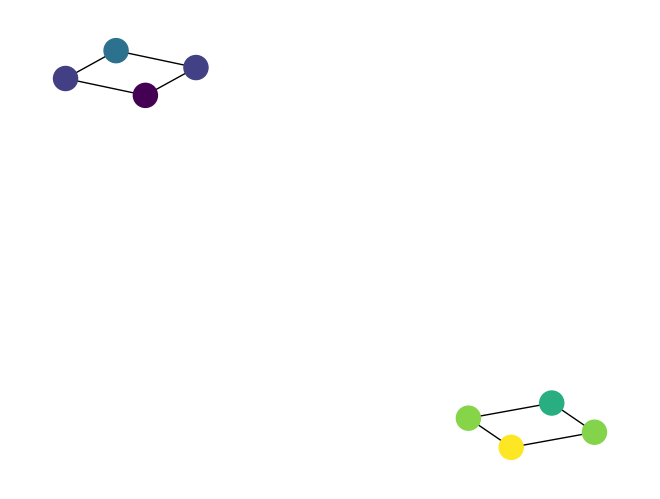

100%|██████████| 150/150 [00:05<00:00, 25.81it/s]


loss: -16.577793323264846
topo_loss: -18.365270220107796
mode:
Indices of rows that are all zeros: (tensor([], dtype=torch.int64),)


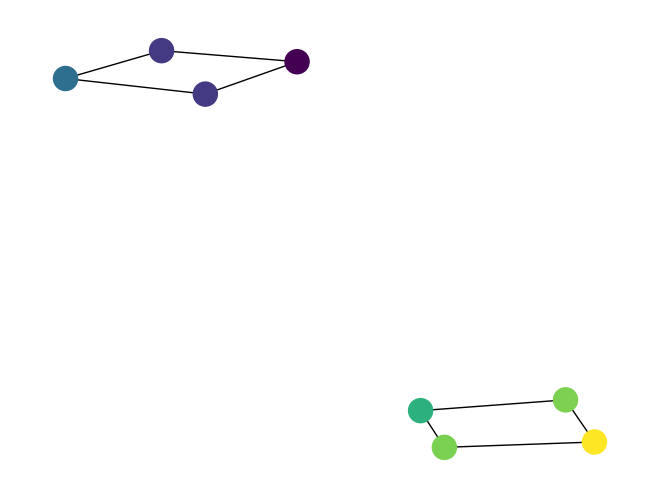

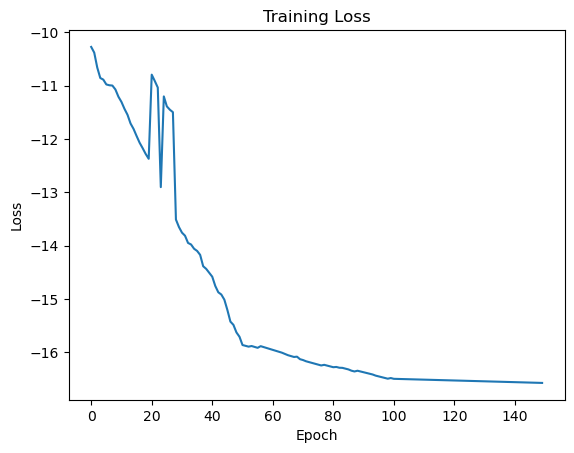

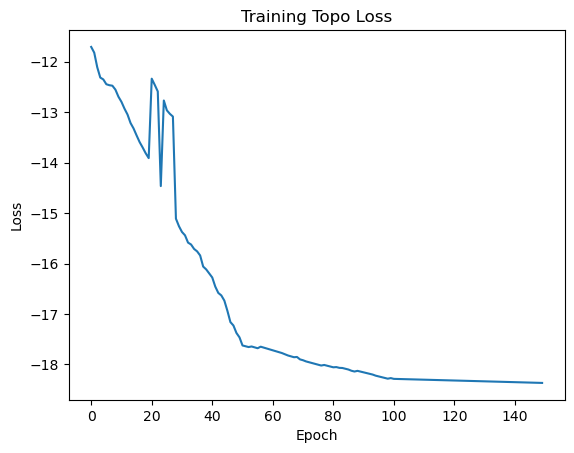

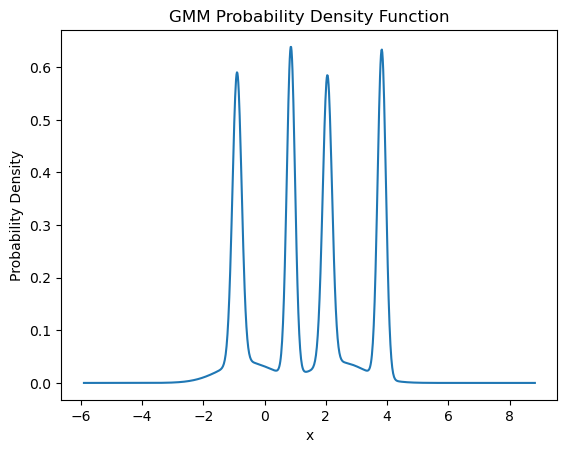

mode:
Indices of rows that are all zeros: (tensor([], dtype=torch.int64),)


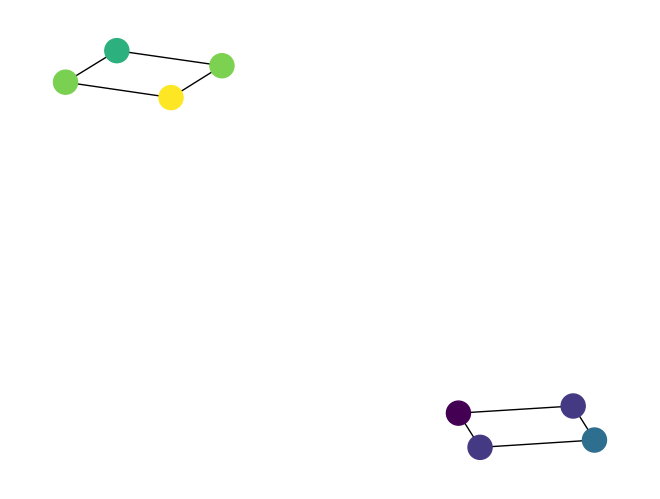

In [103]:
# data
csv_file = 'data/two_cir.csv'
data = np.loadtxt(csv_file,delimiter=",")
data = torch.tensor(data)
projected_data = data[:,0]
projected_data = projected_data.view(len(data), 1)

# init parameters
n_comp = 6
num_step = 150
l1 = 1
l2 = 1 

# GMM initialization
gmm = GaussianMixture(n_components=n_comp, covariance_type='full', n_init = 10,
                      max_iter= 1000,tol=1e-6,random_state = 0 )
gmm.fit(projected_data)
init_mean = torch.tensor(gmm.means_).view(-1)
init_var = torch.tensor(gmm.covariances_).view(-1)
init_weights = torch.tensor(gmm.weights_).view(-1)
db = DBSCAN(eps=0.6,  min_samples=5)
m = Opt_GMM_Mapper(n_comp, means = init_mean, covariances=init_var, weights=init_weights)
init_scheme = m.forward(projected_data, data, db)

# mapper before optimization
mapper = Soft_Mapper.GMM_Soft_Mapper(init_scheme, db, data = data, projected_data =projected_data,path='figures',name = '2cn',format = 'eps')
G_mode_before = mapper.mode(save_fig= False)
filtration_k = mapper.mode_filtration[0]
filtration_k = filtration_k[~torch.isnan(filtration_k)]
before_list = filtration_k.detach().numpy()

# define optimizer and scheduler
optimizer = optim.Adam(m.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=1)
scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

# train
train = Trainer(m, db, num_step, optimizer, scheduler)
train.fit(data, projected_data, l1, l2)
train.analysis()

# mapper after optimization
after_mapper = Soft_Mapper.GMM_Soft_Mapper(train.scheme, db, data = data, projected_data =projected_data,path='figures',name = '2cn',format = 'eps')
G_mode_after = after_mapper.mode(save_fig= False)
filtration_k = after_mapper.mode_filtration[0]
filtration_k = filtration_k[~torch.isnan(filtration_k)]
after_list = filtration_k.detach().numpy()

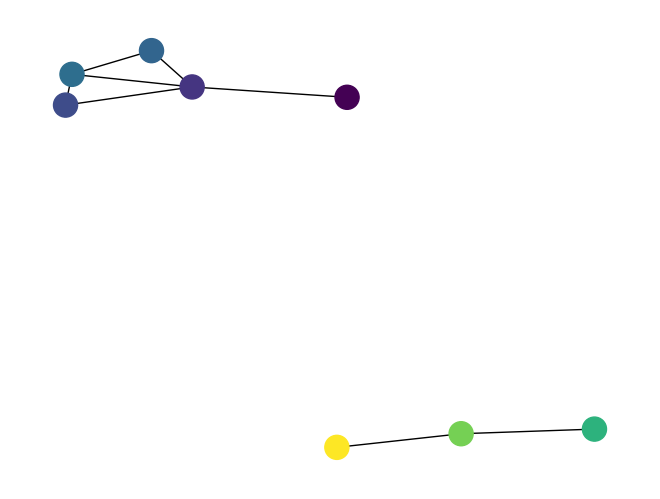

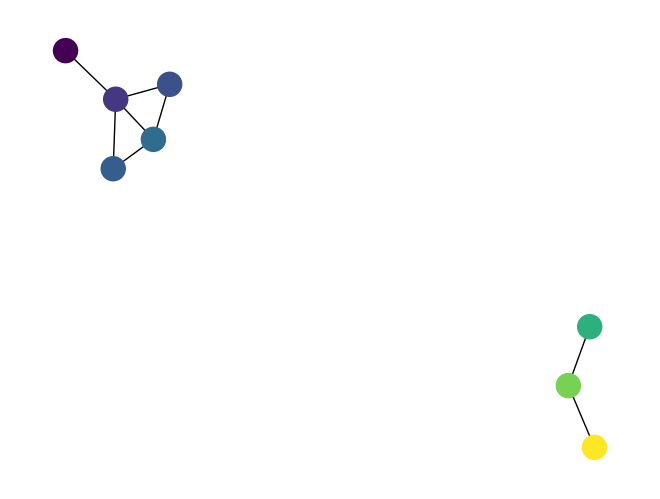

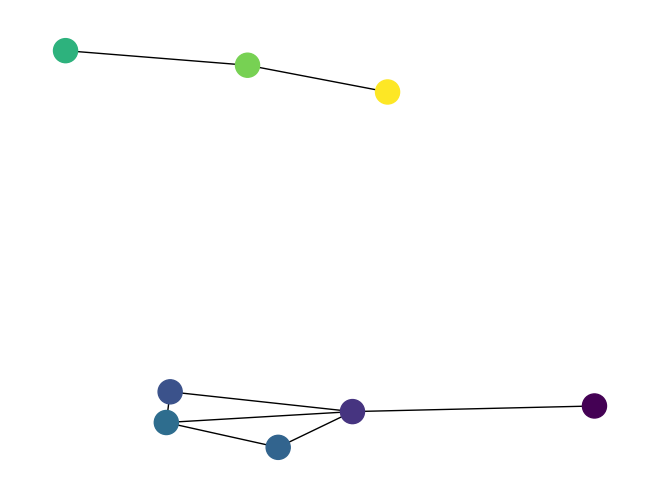

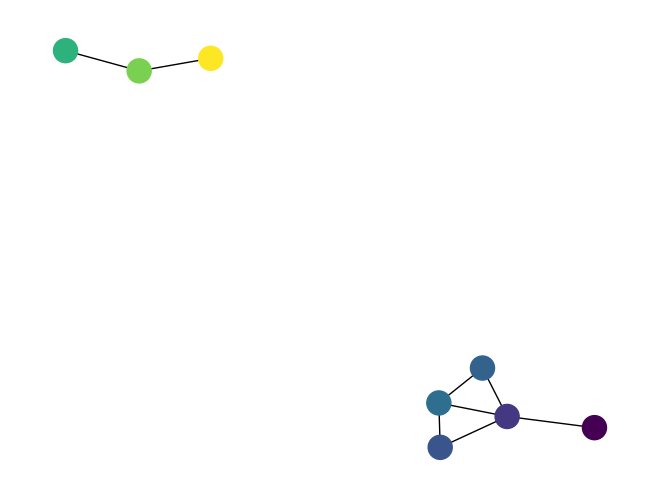

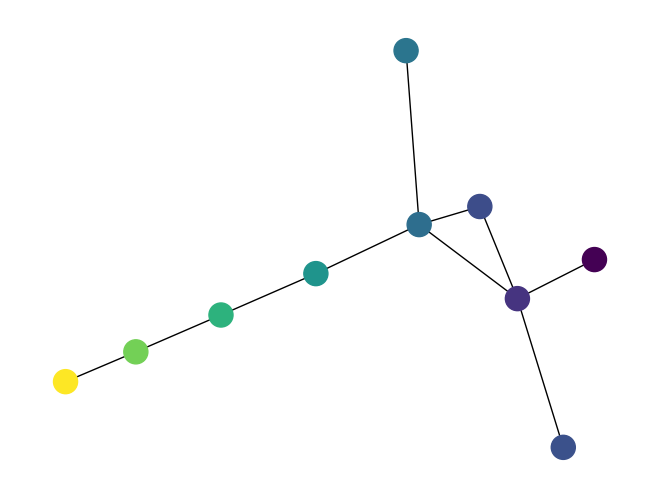

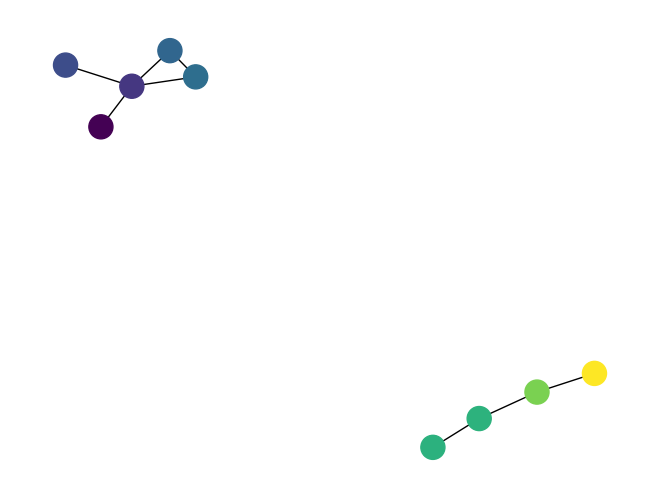

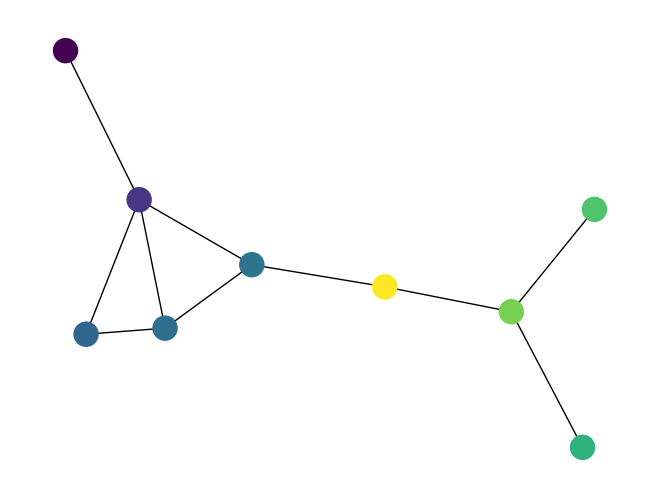

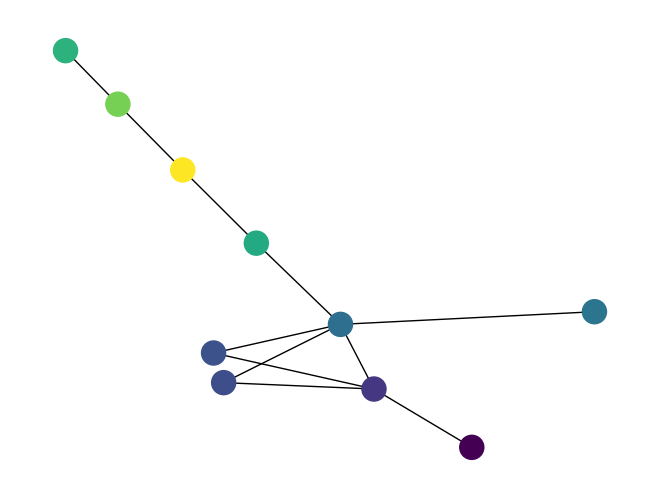

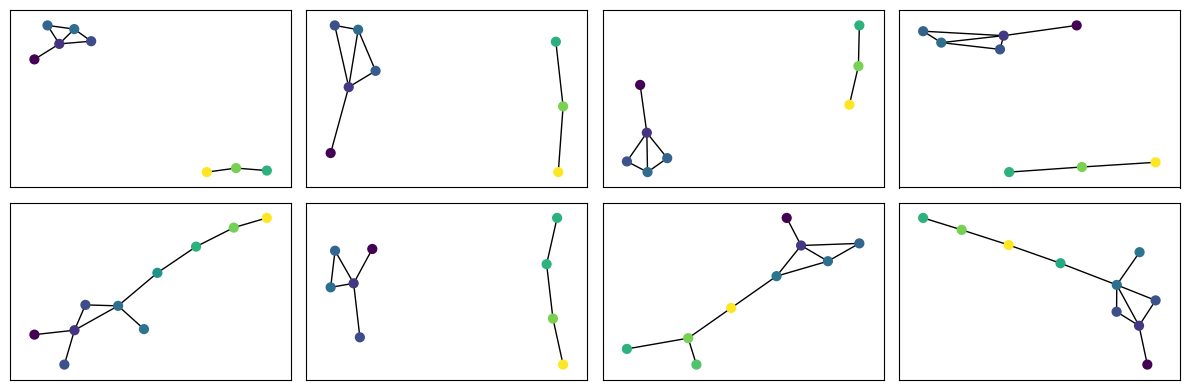

In [104]:
mapper = Soft_Mapper.GMM_Soft_Mapper(train.scheme, db, data = data, projected_data =projected_data
                                     ,path='figures',name = '2cn',format = 'eps')
G_list = mapper.sample(8,plot_num = None, save_fig = False)

plt.figure(figsize=(12, 4))

for i, G in enumerate(G_list):
    ax = plt.subplot(2, 4, i+1)  
    pos = nx.spring_layout(G)  
    filtration_k = mapper.filtration[i]
    filtration_k = filtration_k[~torch.isnan(filtration_k)]

    nx.draw_networkx(G, pos, with_labels=False,node_color = filtration_k,node_size = 40)
    ax.set_xticks([]) 
    ax.set_yticks([])  

plt.tight_layout()
plt.savefig('figures/2c.eps', bbox_inches='tight')
plt.show()

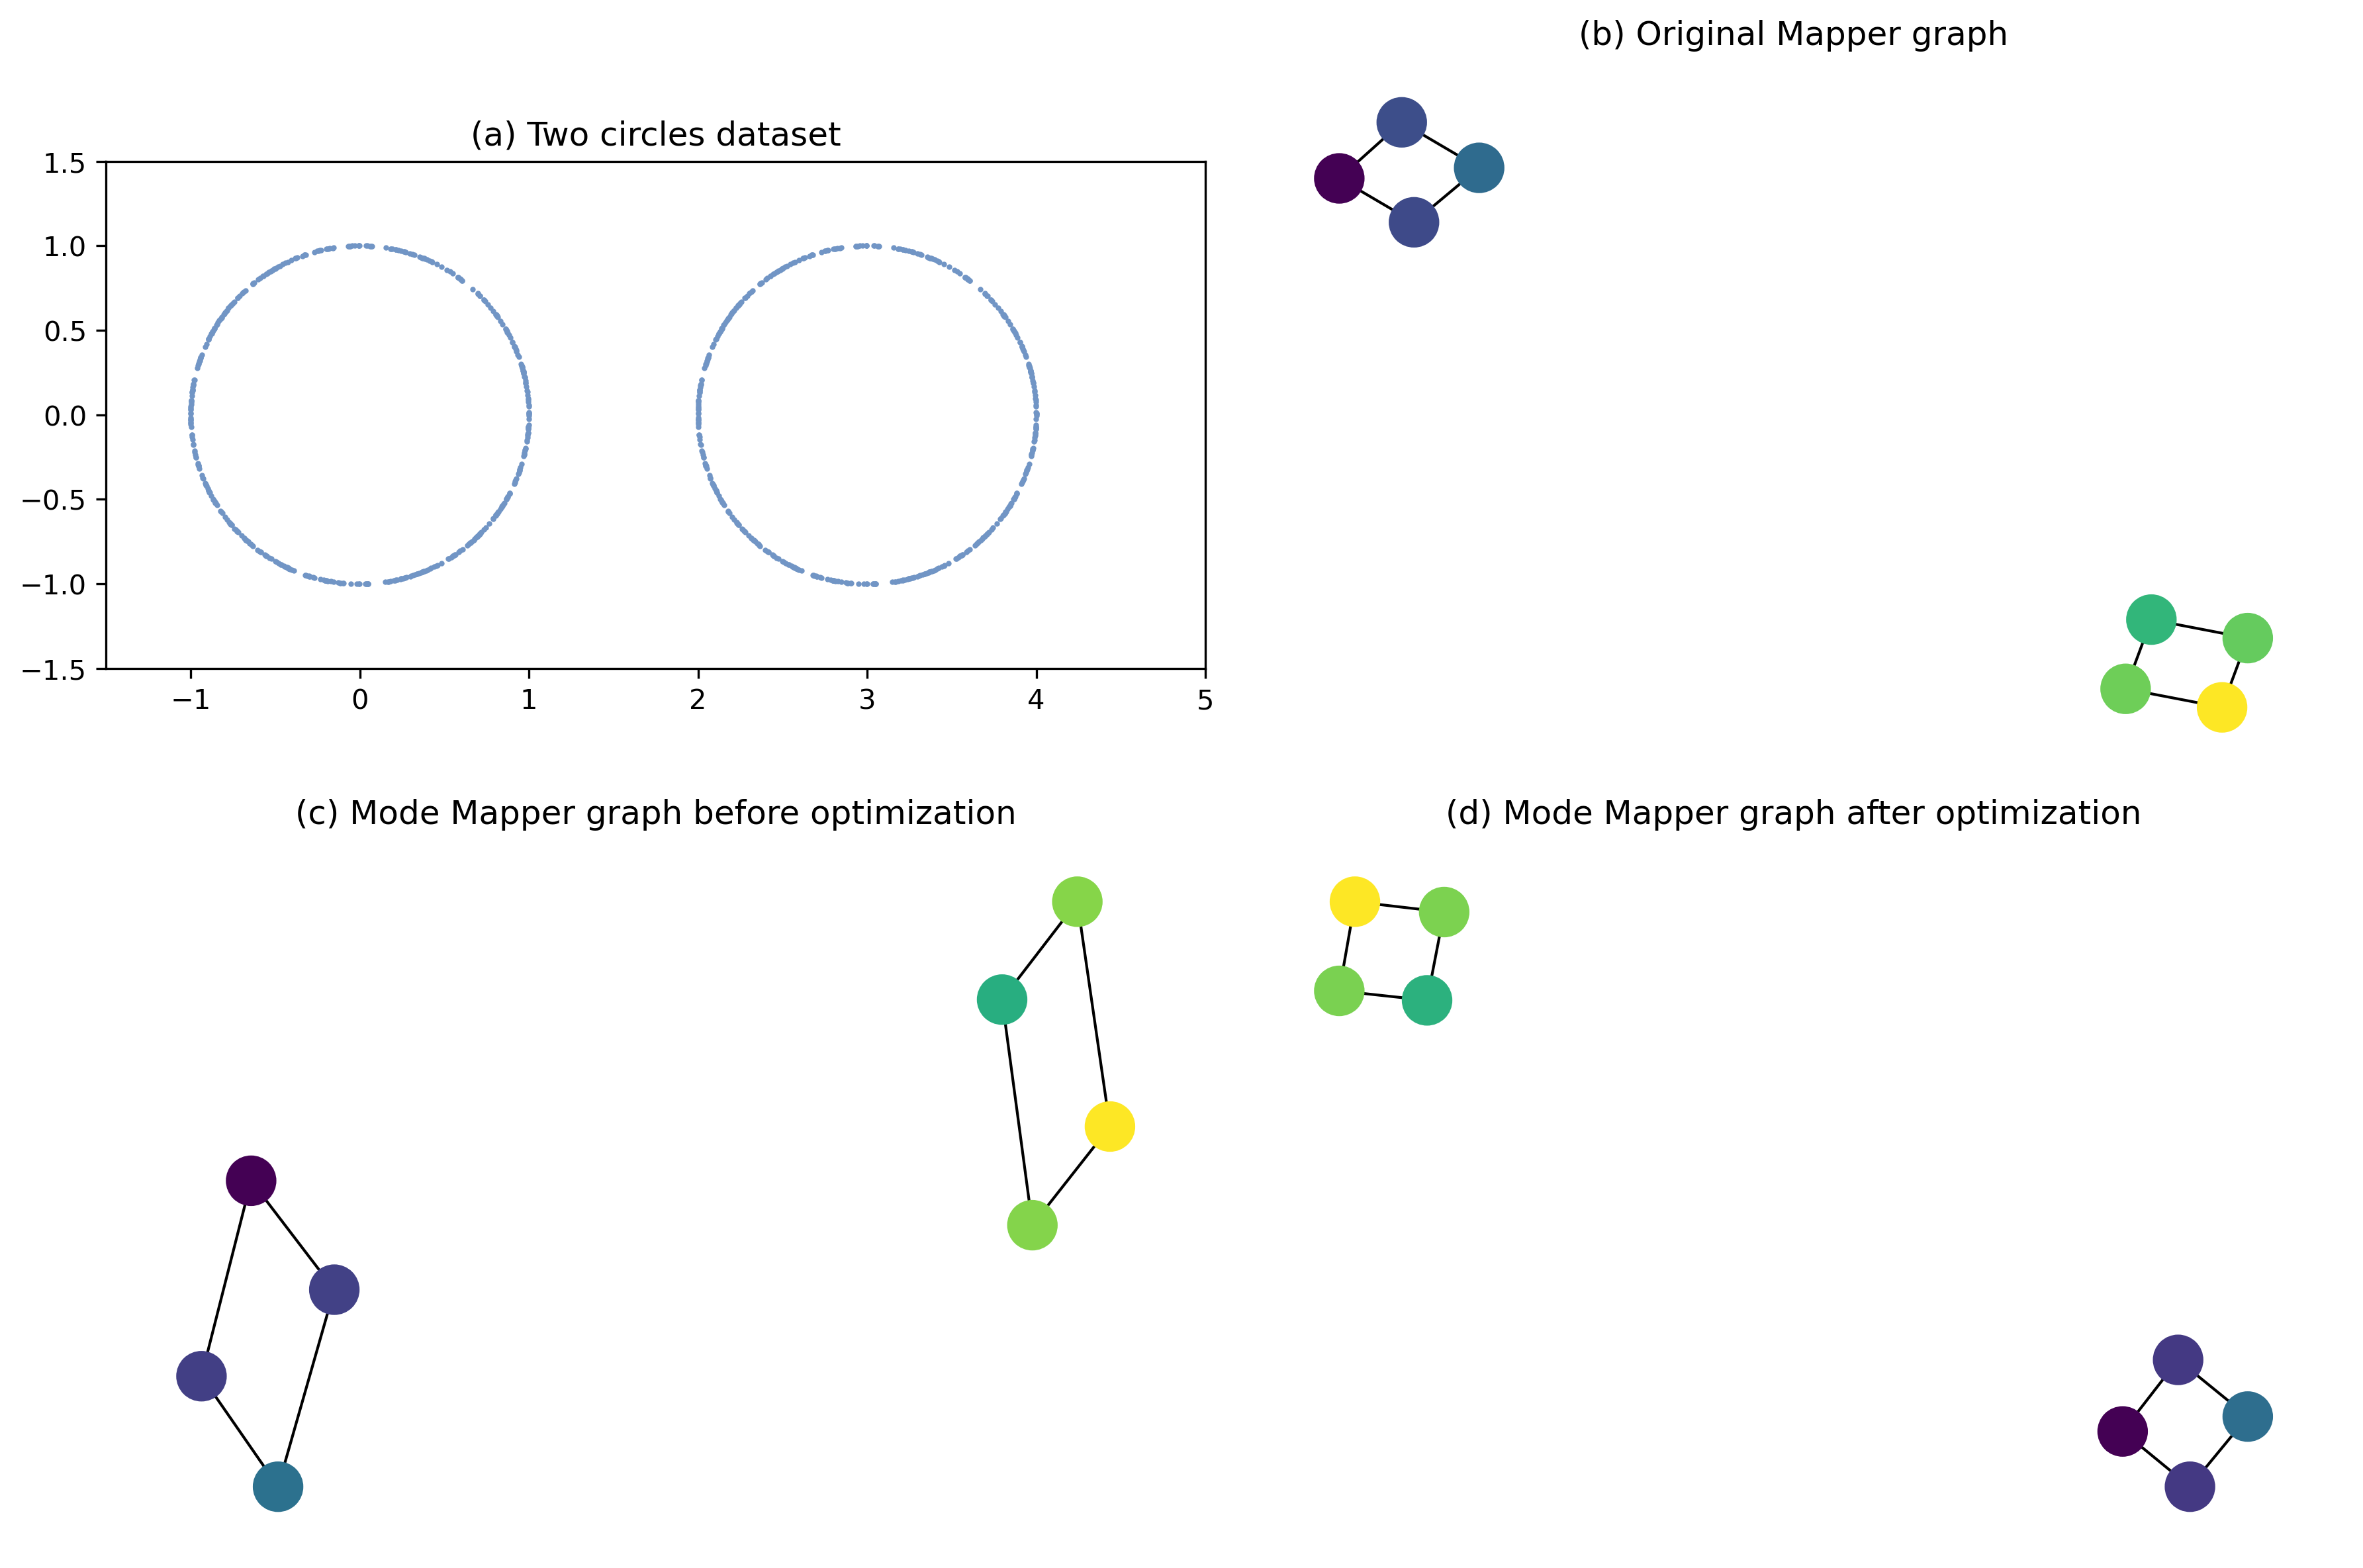

In [105]:
mapper = MapperComplex(
resolutions=n_comp,
gains=0.33,
clustering=db,
)
mapper.fit(data, filters=projected_data.numpy(),colors=projected_data.numpy())

G = mapper.get_networkx()

fig, axs = plt.subplots(2, 2)  
fig.set_size_inches(12, 8)  
fig.dpi = 300  
data = np.loadtxt("data/two_cir.csv", delimiter=",")
axs[0, 0].scatter(data[:,0],data[:,1],s=1,c='#7195c5')
axs[0, 0].set_aspect('equal', adjustable='box')
axs[0, 0].set_xlim((-1.5, 5))
axs[0, 0].set_ylim((-1.5, 1.5))
nx.draw(G, pos=nx.spring_layout(G), 
        node_color=[mapper.node_info_[v]["colors"][0] for v in G.nodes()],
        ax=axs[0, 1])

nx.draw(G_mode_before, pos=nx.spring_layout(G_mode_before),
        node_color=before_list,
        ax=axs[1, 0]) 

nx.draw(G_mode_after, pos=nx.spring_layout(G_mode_after), 
        node_color=after_list,
        ax=axs[1, 1])  

axs[0, 0].set_title('(a) Two circles dataset')
axs[0, 1].set_title('(b) Original Mapper graph')
axs[1, 0].set_title('(c) Mode Mapper graph before optimization')
axs[1, 1].set_title('(d) Mode Mapper graph after optimization')


plt.tight_layout()
plt.savefig("figures/2c_all.eps")
plt.show()

# two noise circles

mode:
Indices of rows that are all zeros: (tensor([], dtype=torch.int64),)


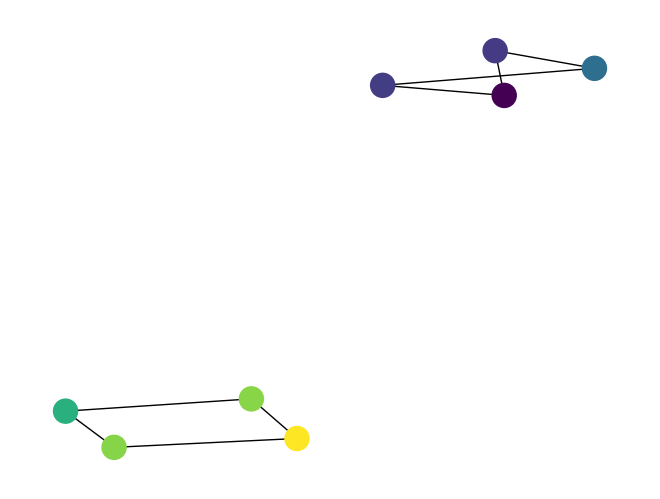

100%|██████████| 150/150 [00:05<00:00, 25.44it/s]

loss: -12.127430599310104
topo_loss: -13.993267723948708
mode:
Indices of rows that are all zeros: (tensor([], dtype=torch.int64),)


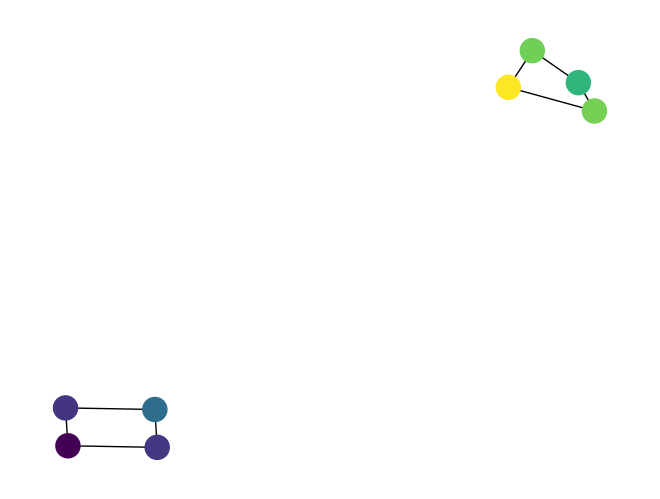

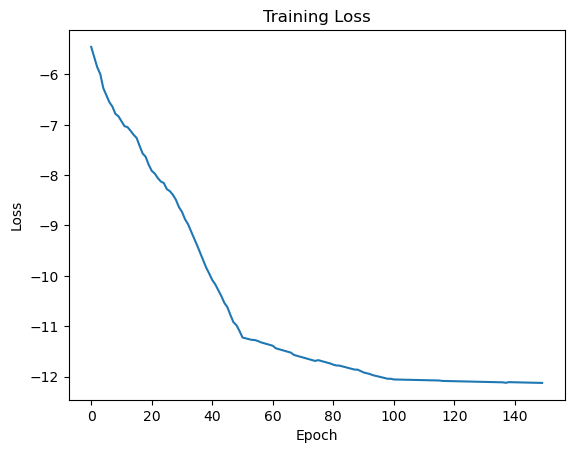

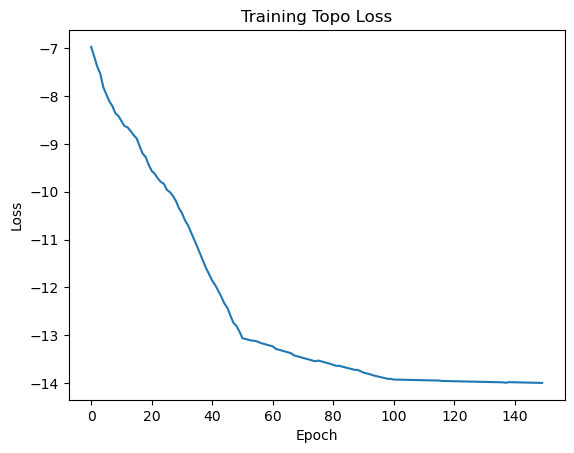

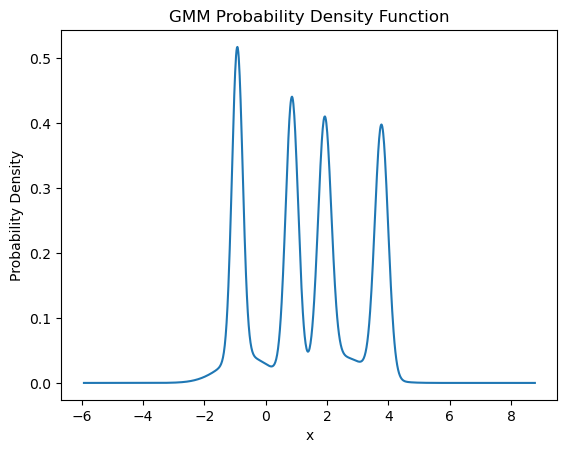

mode:
Indices of rows that are all zeros: (tensor([], dtype=torch.int64),)


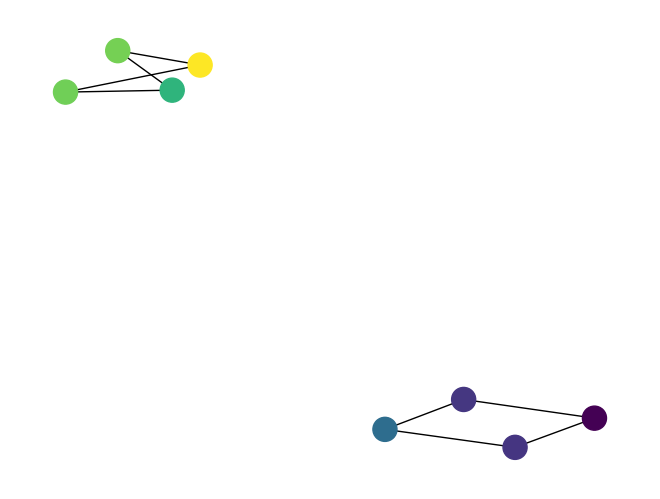

In [106]:
# data
csv_file = 'data/two_cir_noise.csv'
data = np.loadtxt(csv_file,delimiter=",")
data = torch.tensor(data)
projected_data = data[:,0]
projected_data = projected_data.view(len(data), 1)

# init
n_comp = 6
num_step = 150
l1 = 1
l2 = 1 

# GMM initialization
gmm = GaussianMixture(n_components=n_comp, covariance_type='full', n_init = 10,
                      max_iter= 1000,tol=1e-6,random_state = 0 )
gmm.fit(projected_data)
init_mean = torch.tensor(gmm.means_).view(-1)
init_var = torch.tensor(gmm.covariances_).view(-1)
init_weights = torch.tensor(gmm.weights_).view(-1)
db = DBSCAN(eps=0.6,  min_samples=5)
m = Opt_GMM_Mapper(n_comp, means = init_mean, covariances=init_var, weights=init_weights)
init_scheme = m.forward(projected_data, data, db)

# mapper before optimization
mapper = Soft_Mapper.GMM_Soft_Mapper(init_scheme, db, data = data, projected_data =projected_data,path='figures',name = '2cn',format = 'eps')
G_mode_before = mapper.mode(save_fig= False)
filtration_k = mapper.mode_filtration[0]
filtration_k = filtration_k[~torch.isnan(filtration_k)]
before_list = filtration_k.detach().numpy()

# define optimizer and scheduler
optimizer = optim.Adam(m.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=1)
scheduler = lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

# train
train = Trainer(m, db, num_step, optimizer, scheduler)
train.fit(data, projected_data, l1, l2)
train.analysis()

# mapper after optimization
after_mapper = Soft_Mapper.GMM_Soft_Mapper(train.scheme, db, data = data, projected_data =projected_data,path='figures',name = '2cn',format = 'eps')
G_mode_after = after_mapper.mode(save_fig= False)
filtration_k = after_mapper.mode_filtration[0]
filtration_k = filtration_k[~torch.isnan(filtration_k)]
after_list = filtration_k.detach().numpy()

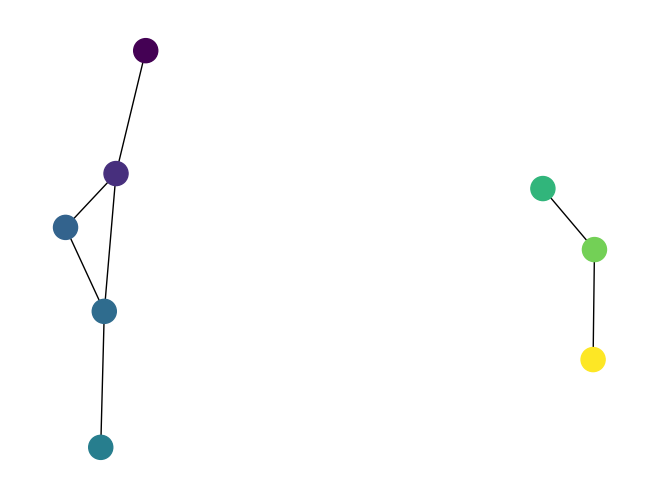

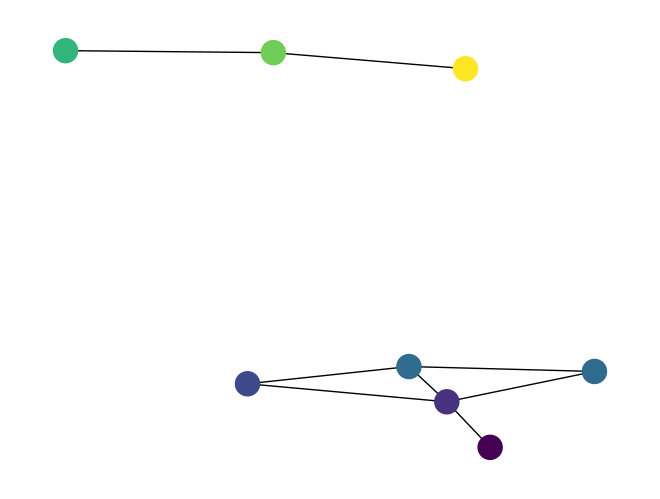

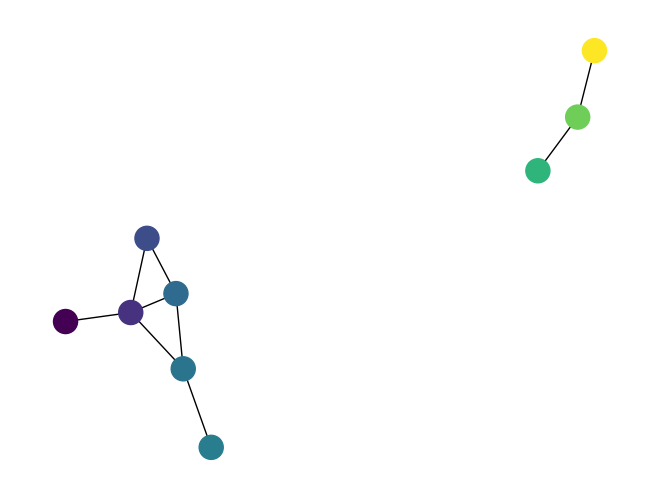

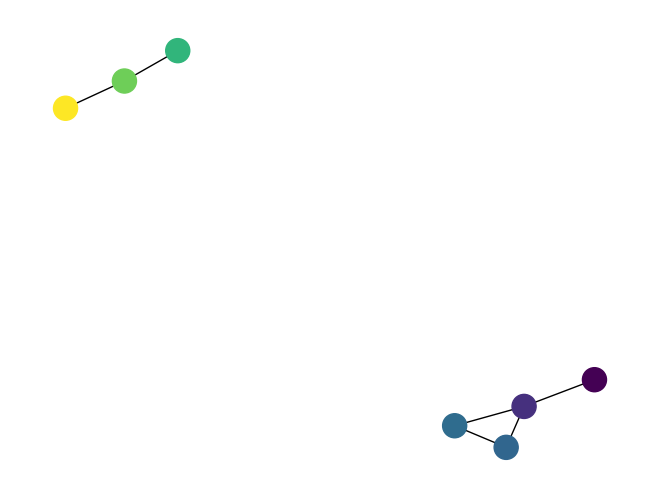

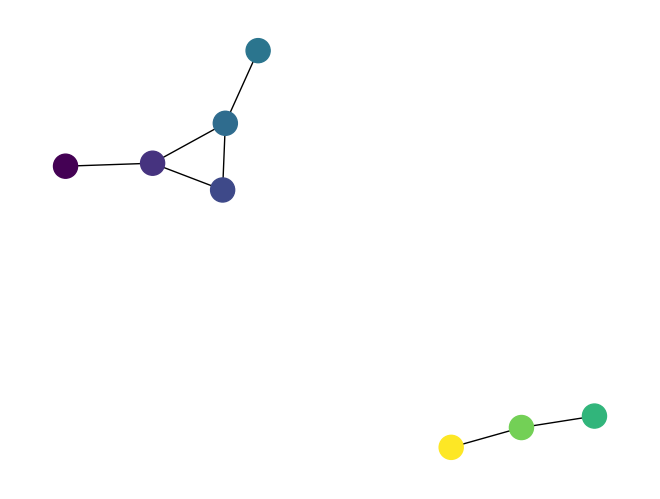

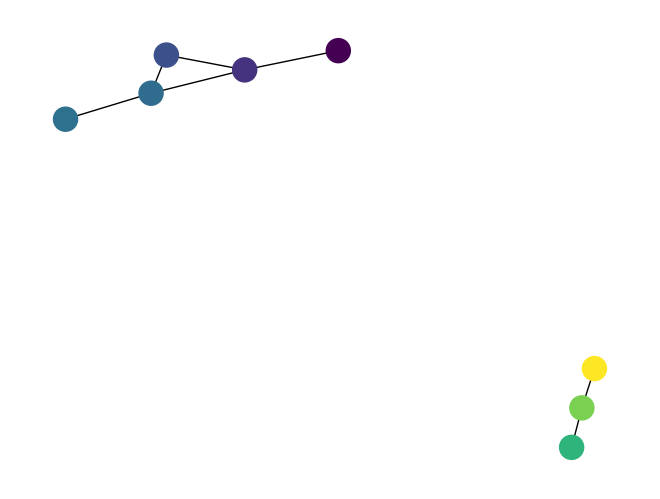

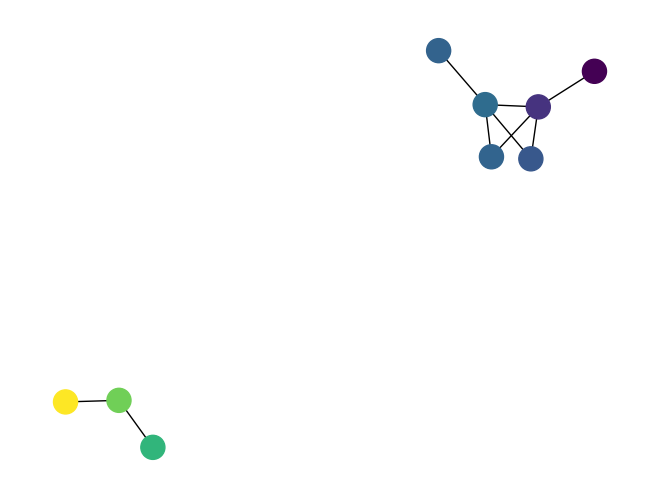

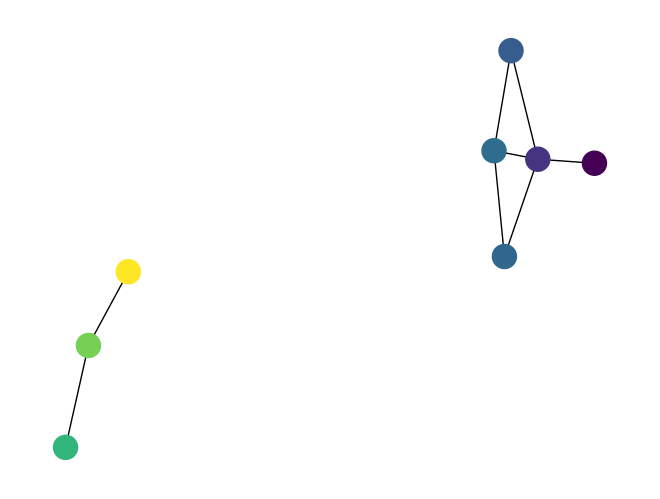

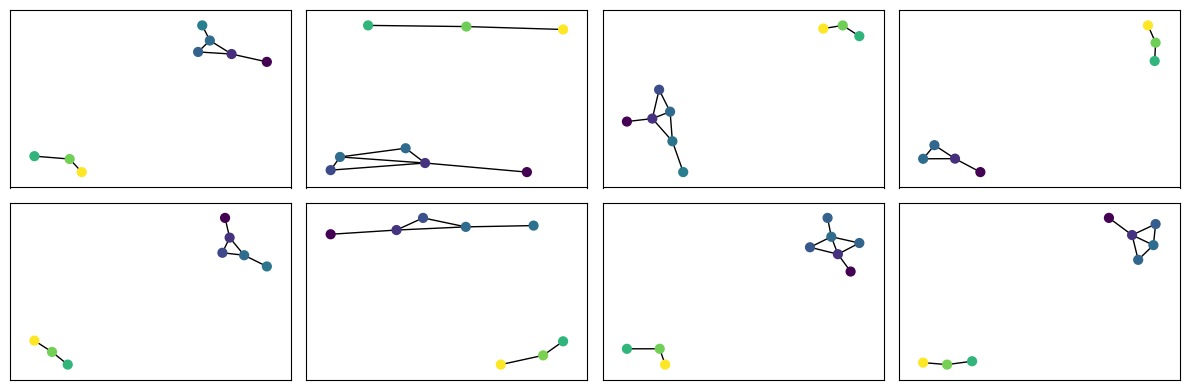

In [107]:
mapper = Soft_Mapper.GMM_Soft_Mapper(train.scheme, db, data = data, projected_data =projected_data
                                     ,path='figures',name = '2cn',format = 'eps')
G_list = mapper.sample(8,plot_num = None, save_fig = False)
plt.figure(figsize=(12, 4))

for i, G in enumerate(G_list):
    ax = plt.subplot(2, 4, i+1)  
    pos = nx.spring_layout(G)  
    filtration_k = mapper.filtration[i]
    filtration_k = filtration_k[~torch.isnan(filtration_k)]

    nx.draw_networkx(G, pos, with_labels=False,node_color = filtration_k,node_size = 40)
    ax.set_xticks([])  
    ax.set_yticks([])  


plt.tight_layout()
plt.savefig('figures/2cn.eps', bbox_inches='tight')
plt.show()

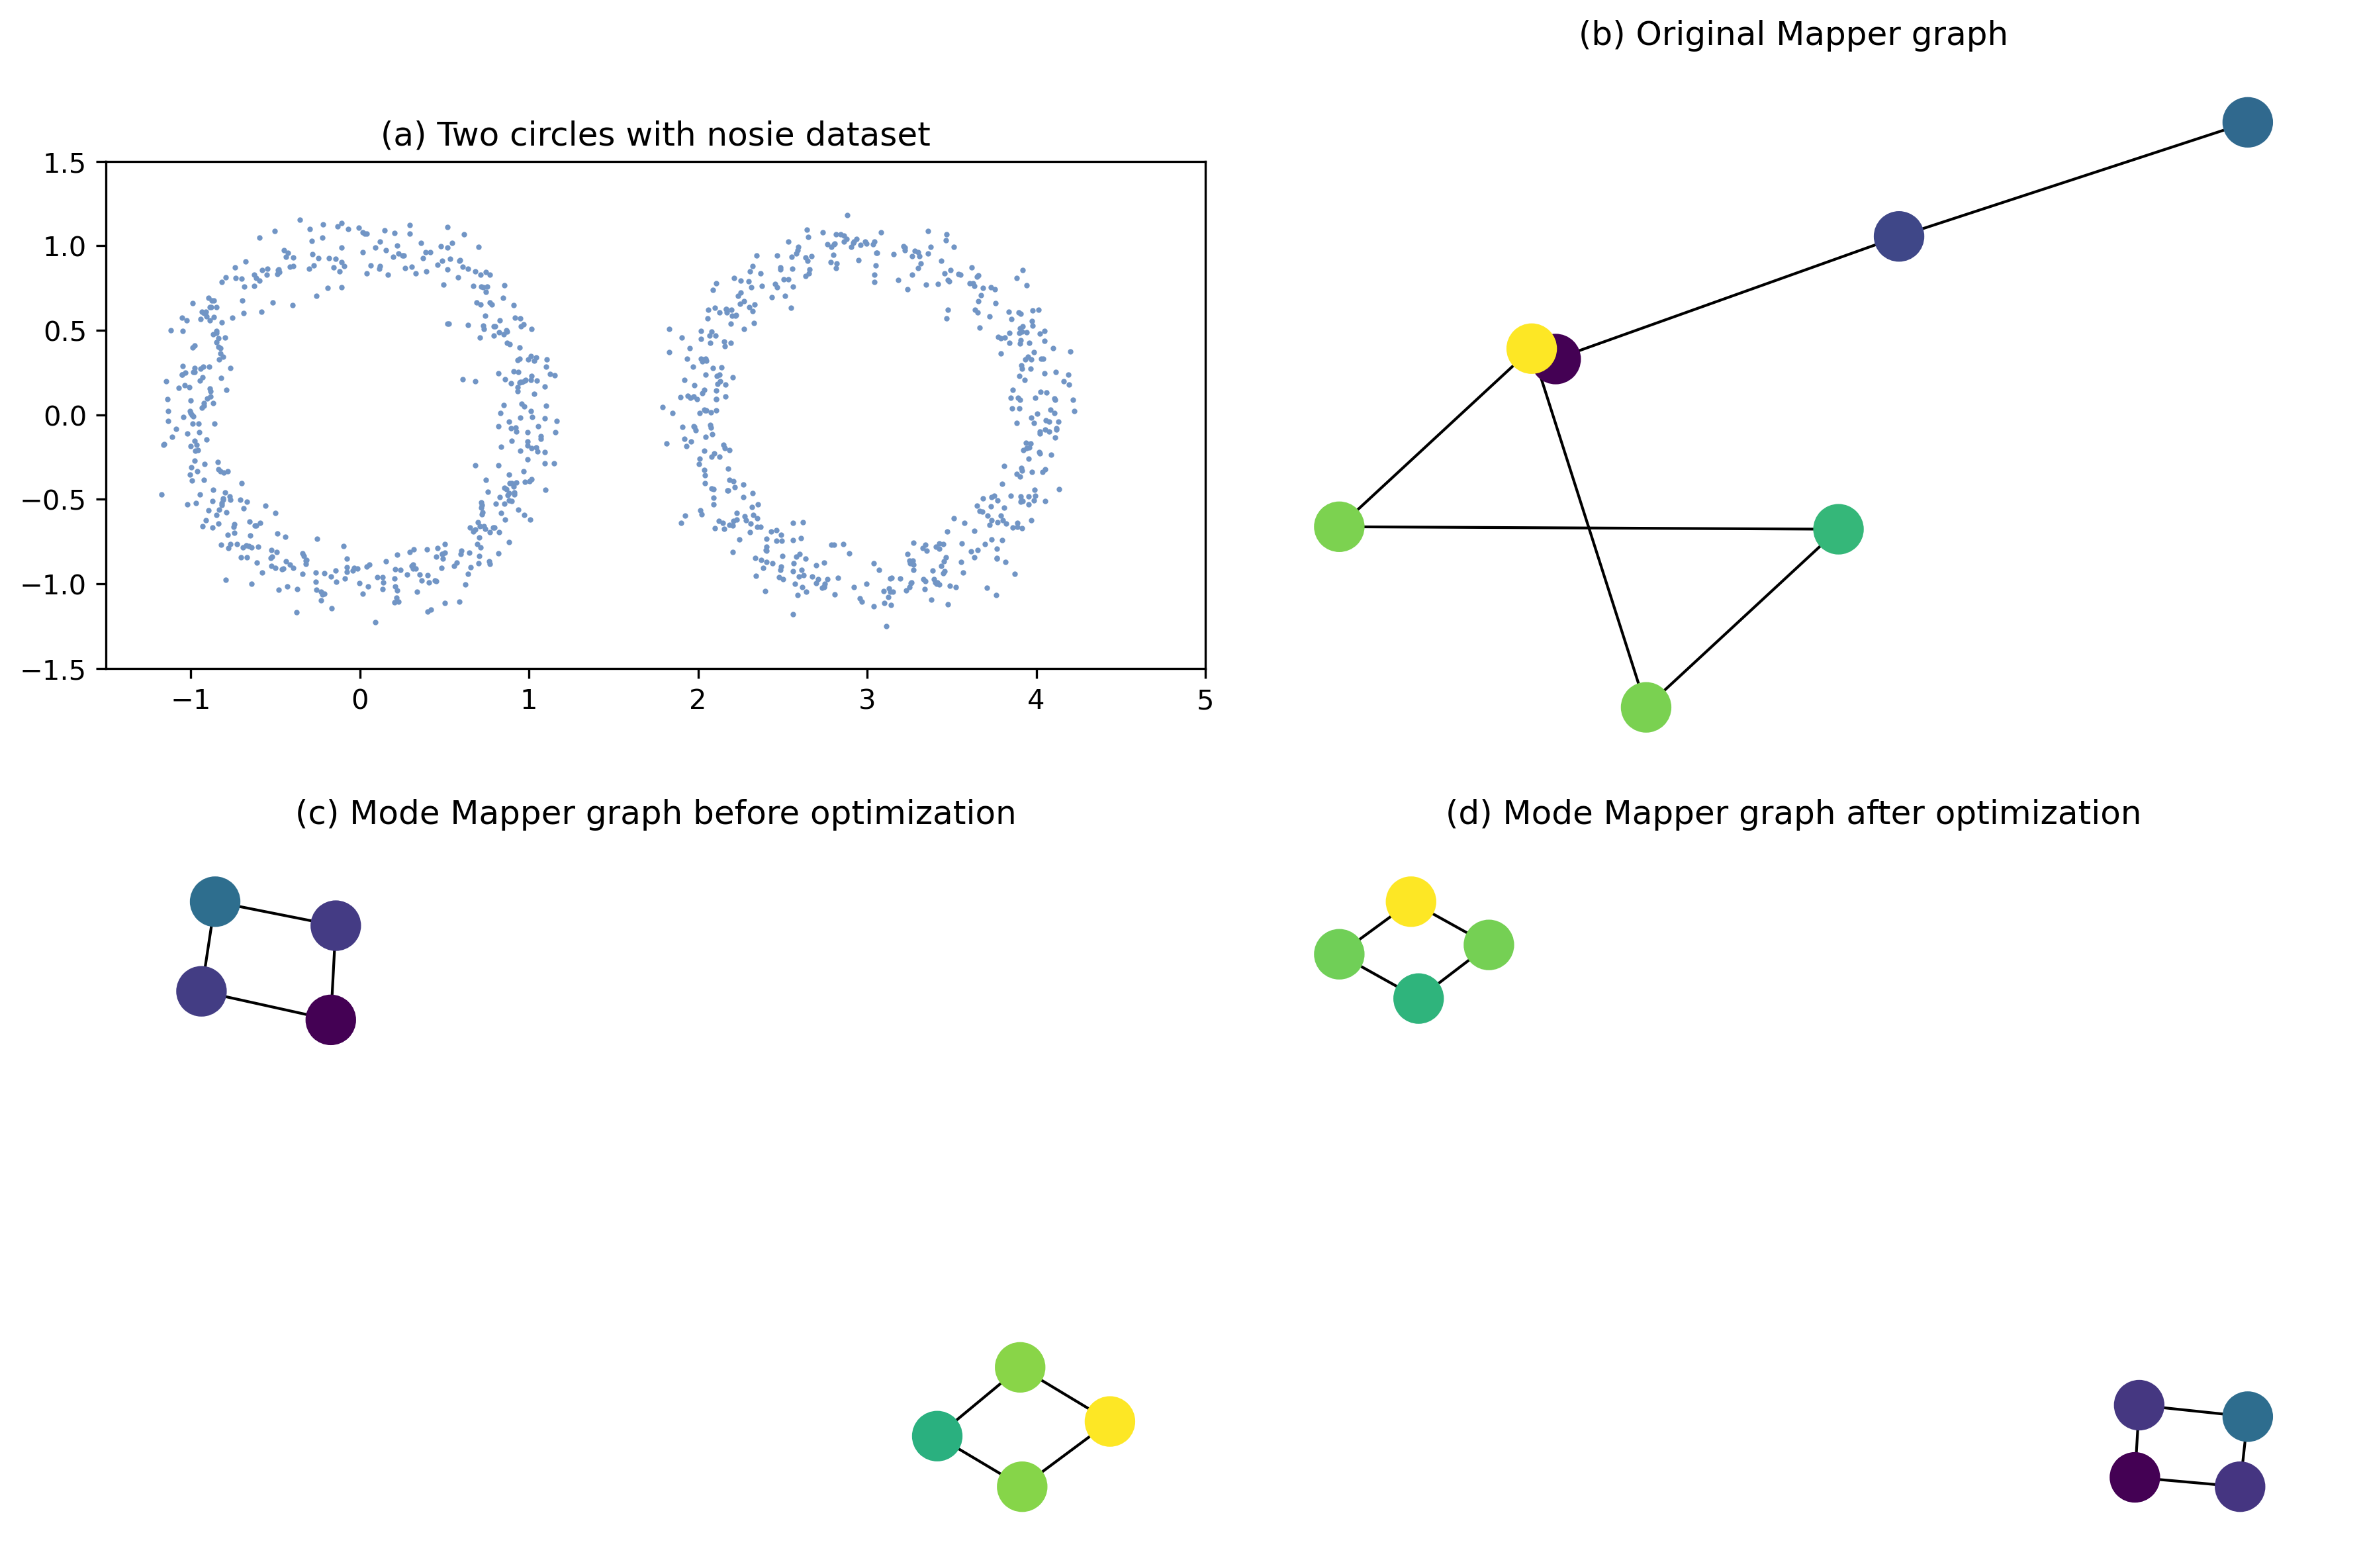

In [108]:
mapper = MapperComplex(
resolutions=n_comp,
gains=0.33,
clustering=db,
)
mapper.fit(data, filters=projected_data.numpy(),colors=projected_data.numpy())

G = mapper.get_networkx()

fig, axs = plt.subplots(2, 2)  
fig.set_size_inches(12, 8)  
fig.dpi = 300  

data = np.loadtxt("data/two_cir_noise.csv", delimiter=",")
axs[0, 0].scatter(data[:,0],data[:,1],s=1,c='#7195c5')
axs[0, 0].set_aspect('equal', adjustable='box')
axs[0, 0].set_xlim((-1.5, 5))
axs[0, 0].set_ylim((-1.5, 1.5))
nx.draw(G, pos=nx.kamada_kawai_layout(G), 
        node_color=[mapper.node_info_[v]["colors"][0] for v in G.nodes()],
        ax=axs[0, 1])

nx.draw(G_mode_before, pos=nx.spring_layout(G_mode_before),
        node_color=before_list,
        ax=axs[1, 0]) 

nx.draw(G_mode_after, pos=nx.spring_layout(G_mode_after), 
        node_color=after_list,
        ax=axs[1, 1])  

axs[0, 0].set_title('(a) Two circles with nosie dataset')
axs[0, 1].set_title('(b) Original Mapper graph')
axs[1, 0].set_title('(c) Mode Mapper graph before optimization')
axs[1, 1].set_title('(d) Mode Mapper graph after optimization')


plt.tight_layout()
plt.savefig("figures/2cn_all.eps")
plt.show()

# two intersecting cir

mode:
Indices of rows that are all zeros: (tensor([], dtype=torch.int64),)


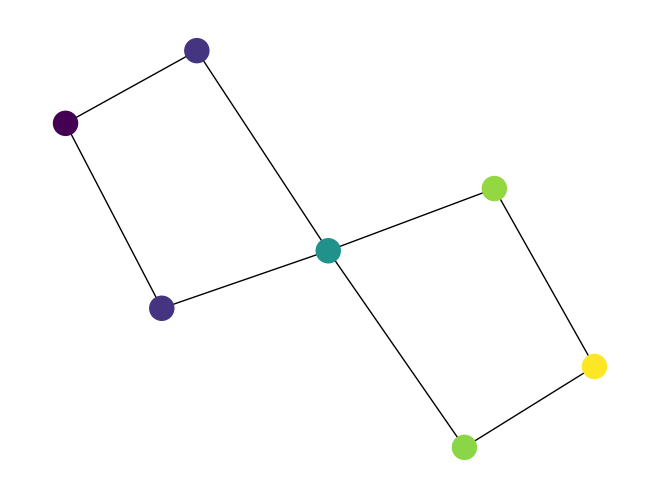

100%|██████████| 300/300 [00:10<00:00, 28.03it/s]


loss: -10.50522618738571
topo_loss: -11.87917759031939
mode:
Indices of rows that are all zeros: (tensor([], dtype=torch.int64),)


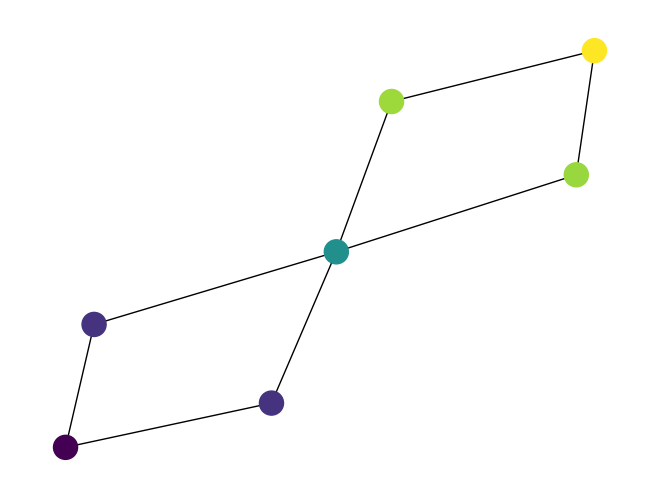

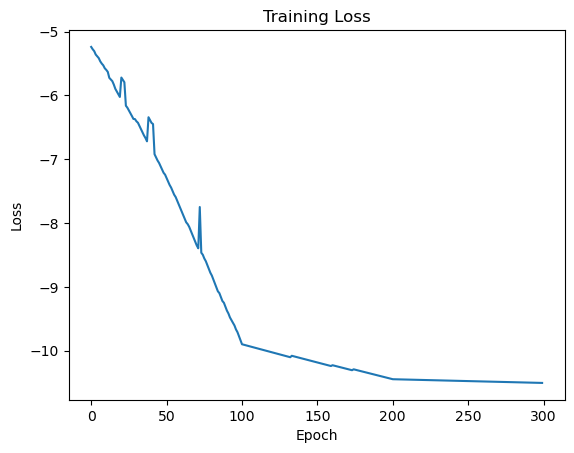

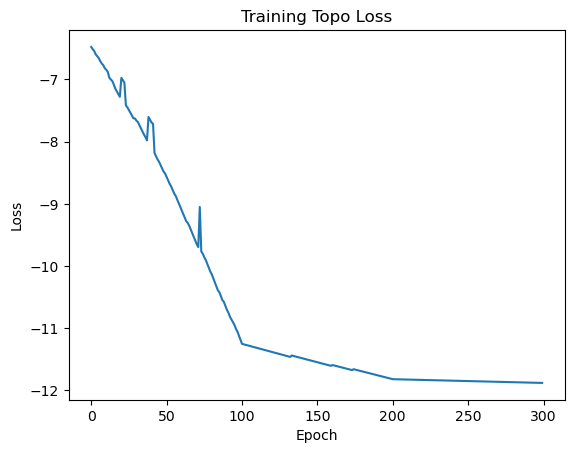

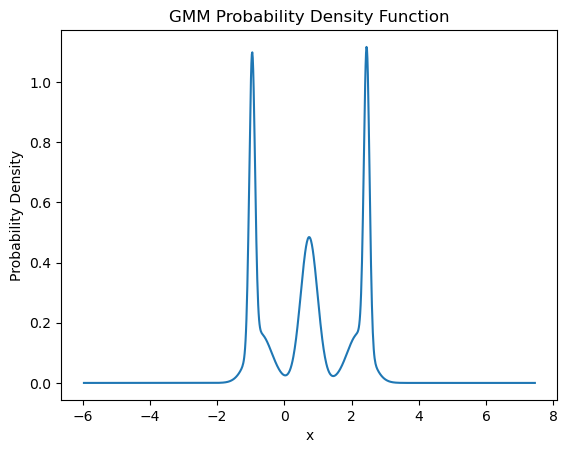

mode:
Indices of rows that are all zeros: (tensor([], dtype=torch.int64),)


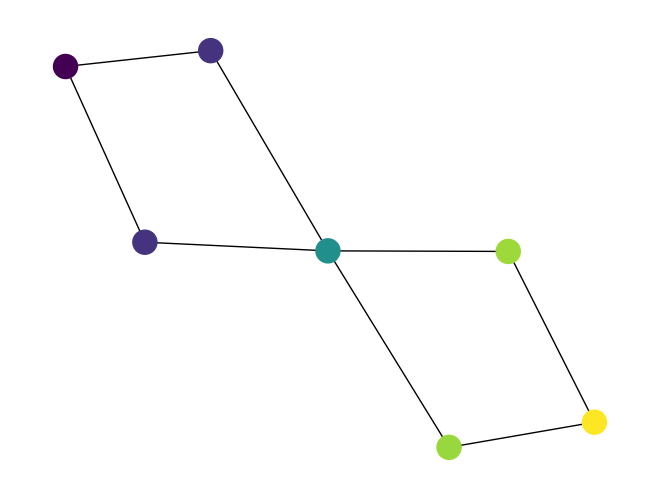

'clusters = train.mode_clusters\nclusters = clusters.squeeze(dim = 0)\nclusters = clusters[:, ~torch.all(clusters == 0, dim=0)]\nfrom scripts.analysis_msbb import qurey_node_id\nnode_7 = qurey_node_id(clusters, 7)\nnode_1 = qurey_node_id(clusters, 1)'

In [2]:
# data
csv_file = 'data/two_insert_cir.csv'
data = np.loadtxt(csv_file,delimiter=",")
data = torch.tensor(data)
projected_data = data[:,0]
projected_data = projected_data.view(len(data), 1)
n = 100 #150

# init
n_comp = 5 # 6
num_step = 300
l1 = 1
l2 = 1 

# GMM initialization
gmm = GaussianMixture(n_components=n_comp, covariance_type='full', n_init = 10,
                      max_iter= 1000,tol=1e-6
                      ,random_state = 0 )
gmm.fit(projected_data)
init_mean = torch.tensor(gmm.means_).view(-1)
init_var = torch.tensor(gmm.covariances_).view(-1)
init_weights = torch.tensor(gmm.weights_).view(-1)
db = DBSCAN(eps=0.5,  min_samples=5)
m = Opt_GMM_Mapper(n_comp, means = init_mean, covariances=init_var, weights=init_weights)
init_scheme = m.forward(projected_data, data, db)

# mapper before optimization
mapper = Soft_Mapper.GMM_Soft_Mapper(init_scheme, db, data = data, projected_data =projected_data,path='figures',name = '2cn',format = 'eps')
G_mode_before = mapper.mode(save_fig= False)
filtration_k = mapper.mode_filtration[0]
filtration_k = filtration_k[~torch.isnan(filtration_k)]
before_list = filtration_k.detach().numpy()

# define optimizer and scheduler
optimizer = optim.Adam(m.parameters(), lr=0.002, betas=(0.9, 0.999), eps=1e-08, weight_decay=1)
scheduler = lr_scheduler.StepLR(optimizer, step_size=n, gamma=0.1)

# train
train = Trainer(m, db, num_step, optimizer, scheduler)
train.fit(data, projected_data, l1, l2)
train.analysis()


# mapper after optimization


after_mapper = Soft_Mapper.GMM_Soft_Mapper(train.scheme, db, data = data, projected_data =projected_data,path='figures',name = '2cn',format = 'eps')
G_mode_after = after_mapper.mode(save_fig= False)
filtration_k = after_mapper.mode_filtration[0]
filtration_k = filtration_k[~torch.isnan(filtration_k)]
after_list = filtration_k.detach().numpy()


# get points in some nodes
'''clusters = train.mode_clusters
clusters = clusters.squeeze(dim = 0)
clusters = clusters[:, ~torch.all(clusters == 0, dim=0)]
from scripts.analysis_msbb import qurey_node_id
node_7 = qurey_node_id(clusters, 7)
node_1 = qurey_node_id(clusters, 1)'''

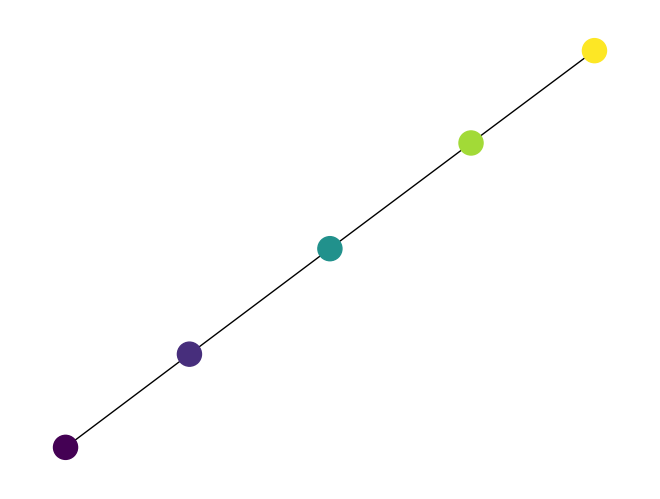

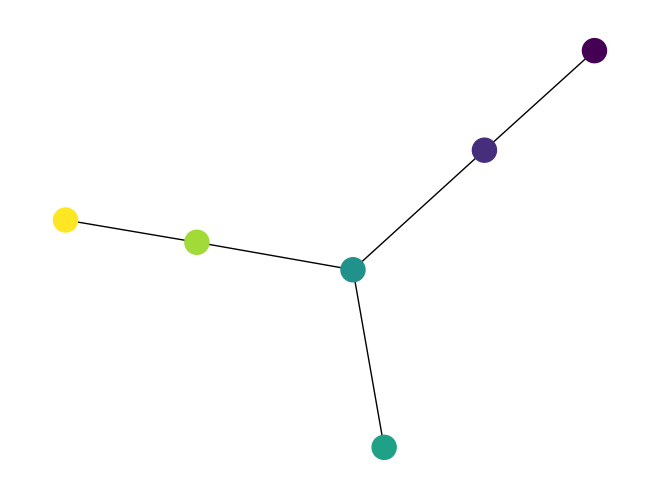

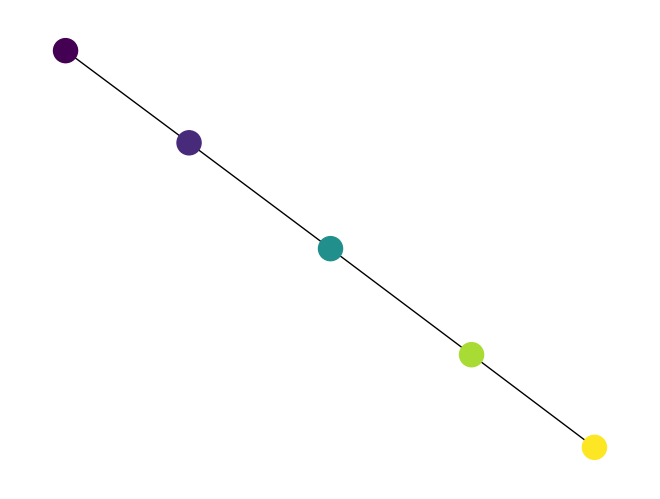

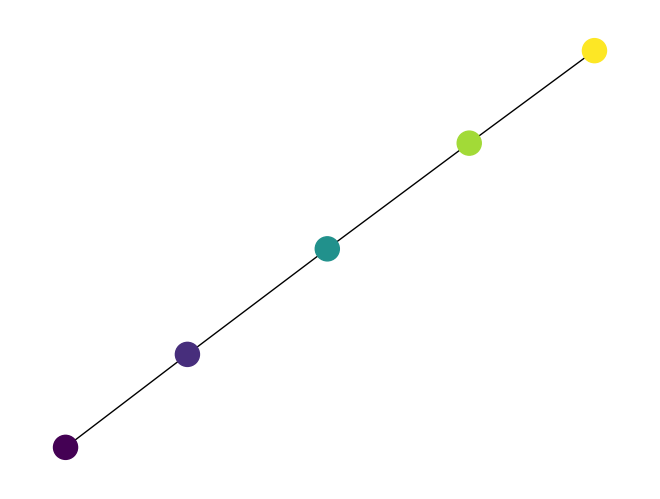

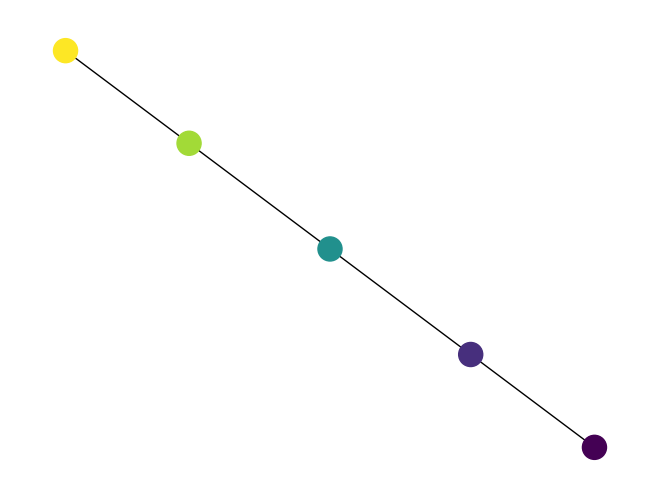

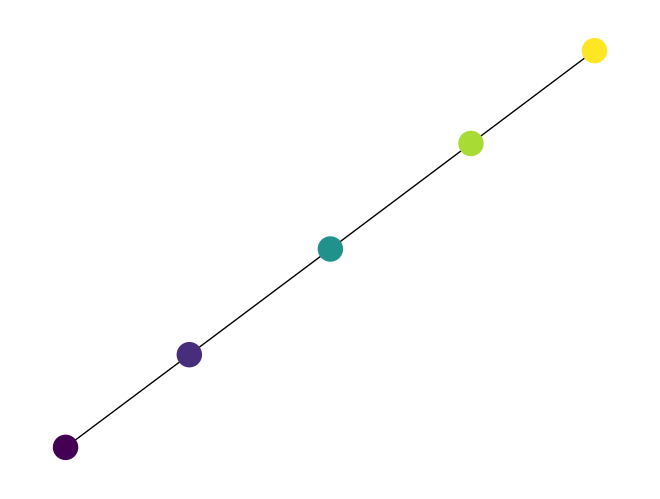

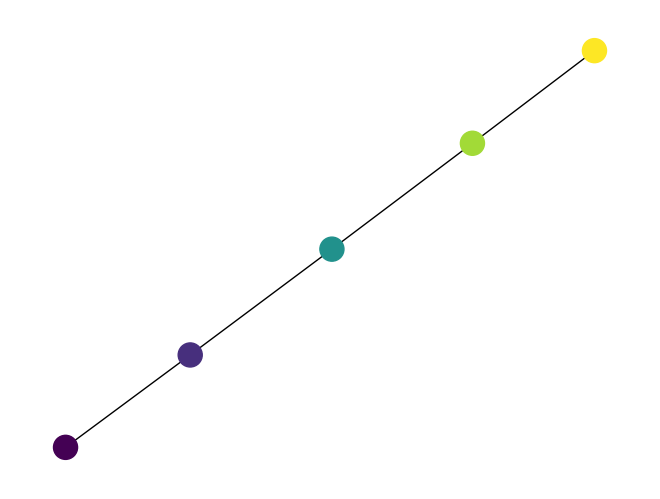

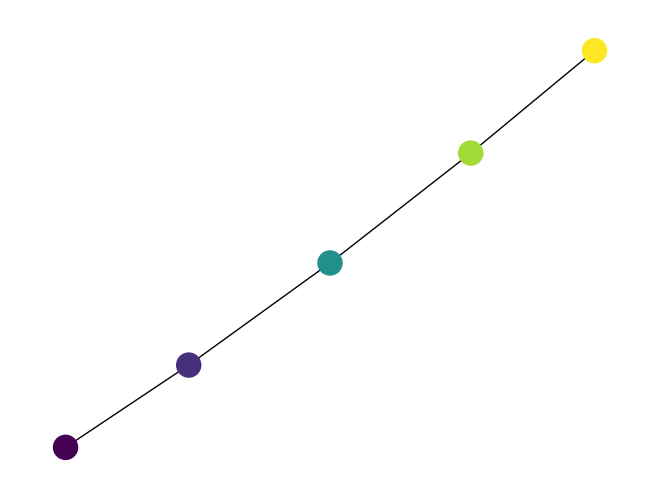

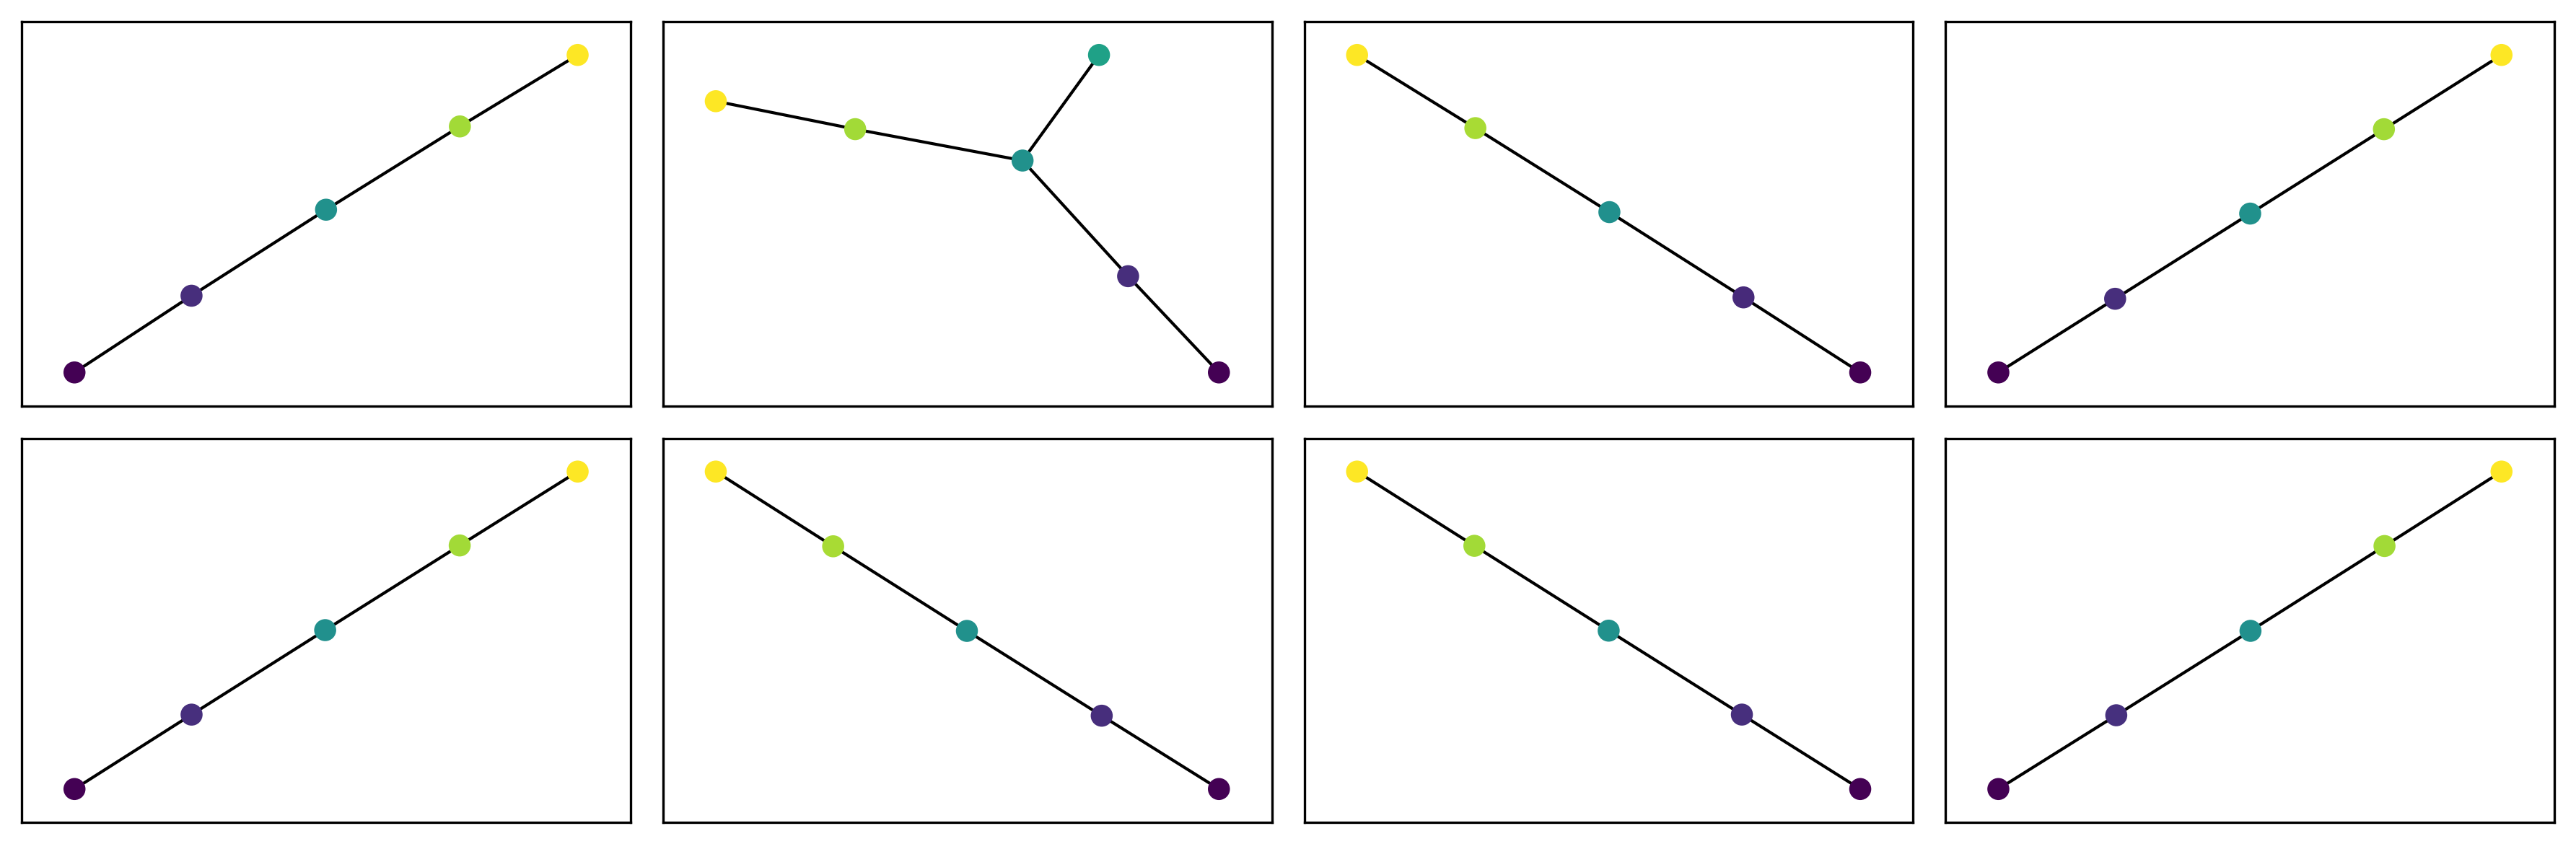

In [3]:
mapper = Soft_Mapper.GMM_Soft_Mapper(train.scheme, db, data = data, projected_data =projected_data
                                     ,path='figures',name = '2ic',format = 'eps')
G_list = mapper.sample(8,plot_num = None, save_fig = False)
plt.figure(figsize=(12, 4), dpi= 300)


for i, G in enumerate(G_list):
    ax = plt.subplot(2, 4, i+1)  
    pos = nx.spring_layout(G)  
    filtration_k = mapper.filtration[i]
    filtration_k = filtration_k[~torch.isnan(filtration_k)]

    nx.draw_networkx(G, pos, with_labels=False,node_color = filtration_k,node_size = 40)
    ax.set_xticks([]) 
    ax.set_yticks([])  

plt.tight_layout()
plt.savefig('figures/2ic.eps', bbox_inches='tight')
plt.show()

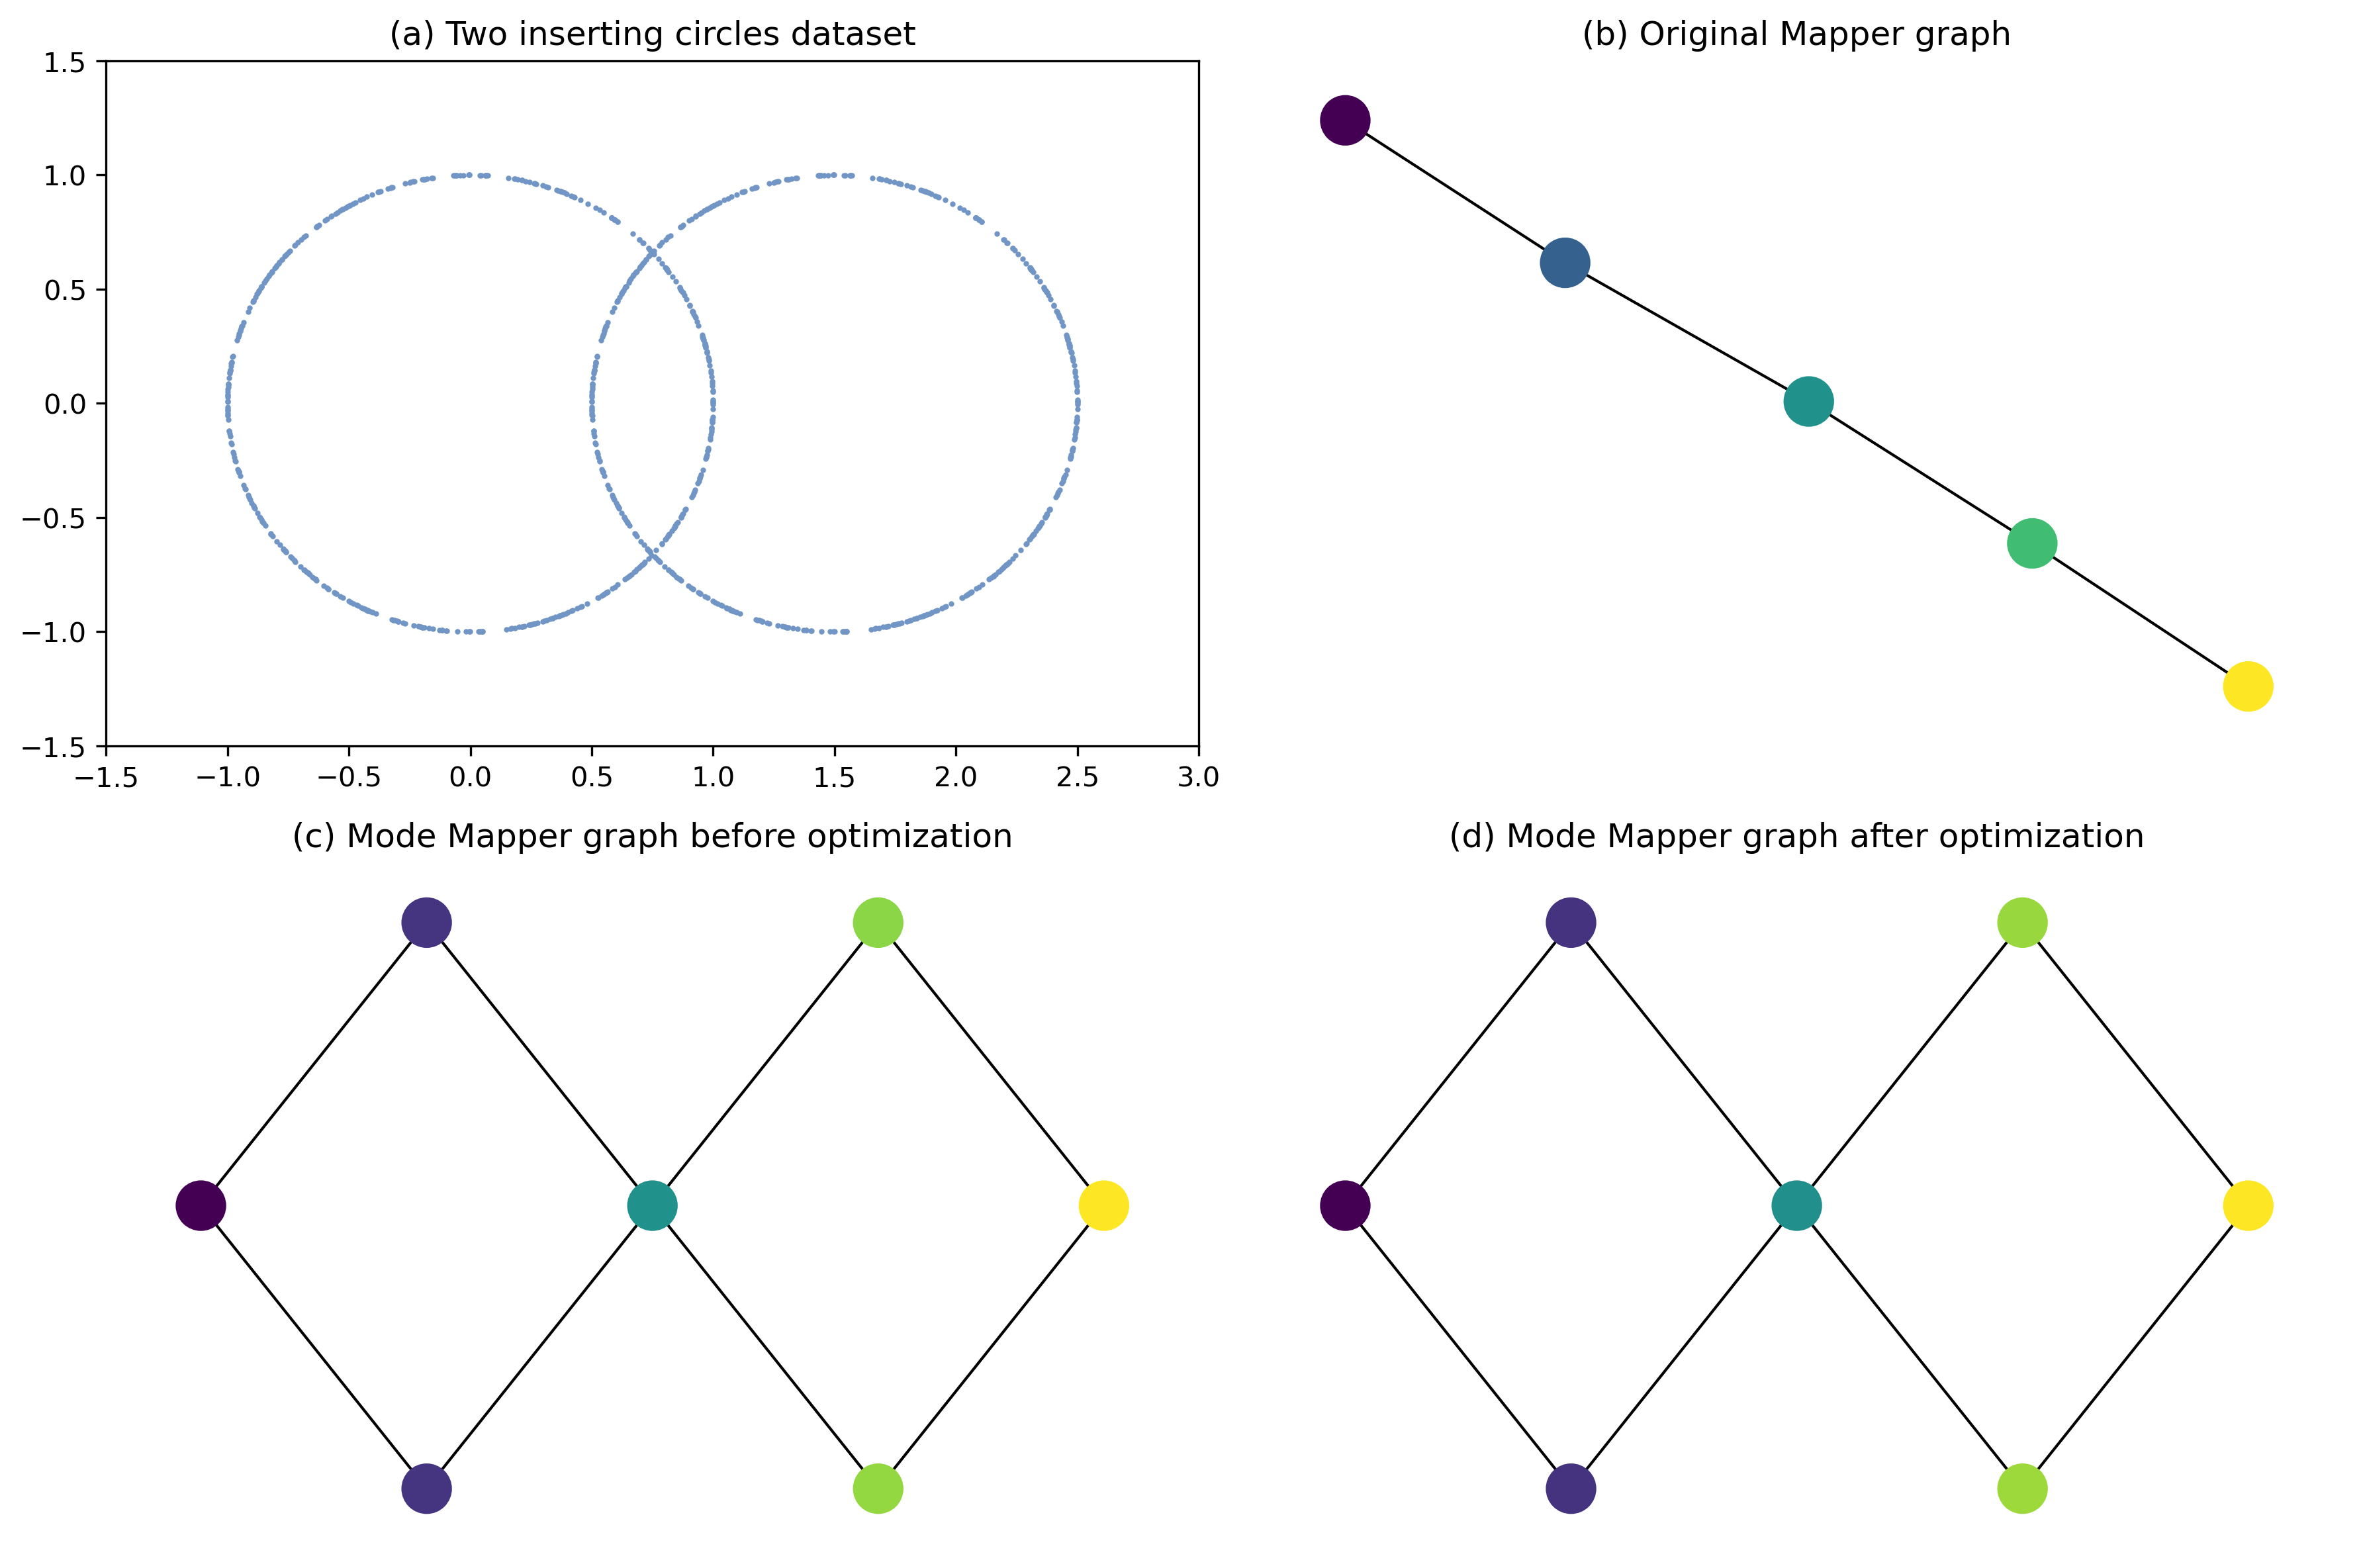

In [6]:
mapper = MapperComplex(
resolutions=n_comp,
gains=0.33,
clustering=db,
)
mapper.fit(data, filters=projected_data.numpy(),colors=projected_data.numpy())
G = mapper.get_networkx()


fig, axs = plt.subplots(2, 2) 
fig.set_size_inches(12, 8)  
fig.dpi = 300  

data = np.loadtxt("data/two_insert_cir.csv", delimiter=",")
axs[0, 0].scatter(data[:,0],data[:,1],s=1,c='#7195c5')
#axs[0, 0].scatter(data[node_7,0],data[node_7,1],s=3,c='#1fa188') #  marker = 'x'
#axs[0, 0].scatter(data[node_1,0],data[node_1,1],s=3,c='red') #  marker = 'x'
axs[0, 0].set_xlim((-1.5, 3))
axs[0, 0].set_ylim((-1.5, 1.5))

'''pos1 = {3: np.array([-0.6,  0.]), 0: np.array([0., 0.]), 5: np.array([0.9, 0.]), 
       7: np.array([0.6, 0.15]), 6: np.array([ 0.6, -0.15]), 4: np.array([0.3, 0.]), 
       1: np.array([-0.3,  0.15]), 2: np.array([-0.3,  -0.15])}'''

nx.draw(G, pos = nx.kamada_kawai_layout(G), 
        node_color=[mapper.node_info_[v]["colors"][0] for v in G.nodes()], 
        ax=axs[0, 1])


pos = {0: np.array([0.3, -0.3]), 1: np.array([0.3, 0.3]), 2: np.array([-0.6, 0.]), 
       3: np.array([0.6, 0.]), 4: np.array([ 0., 0.]), 5: np.array([-0.3, 0.3]), 
       6: np.array([-0.3,  -0.3])}
nx.draw(G_mode_before, pos = pos,
        node_color=before_list,
        ax=axs[1, 0]) 


nx.draw(G_mode_after, pos = pos, 
        node_color=after_list,
        ax=axs[1, 1])   # with_labels = True 

# tittle
axs[0, 0].set_title('(a) Two inserting circles dataset')
axs[0, 1].set_title('(b) Original Mapper graph')
axs[1, 0].set_title('(c) Mode Mapper graph before optimization')
axs[1, 1].set_title('(d) Mode Mapper graph after optimization')

plt.tight_layout()
plt.savefig("figures/2ic_all.eps")
plt.show()

# two nosiy intersecting cir

Before:
mode:
Indices of rows that are all zeros: (tensor([], dtype=torch.int64),)


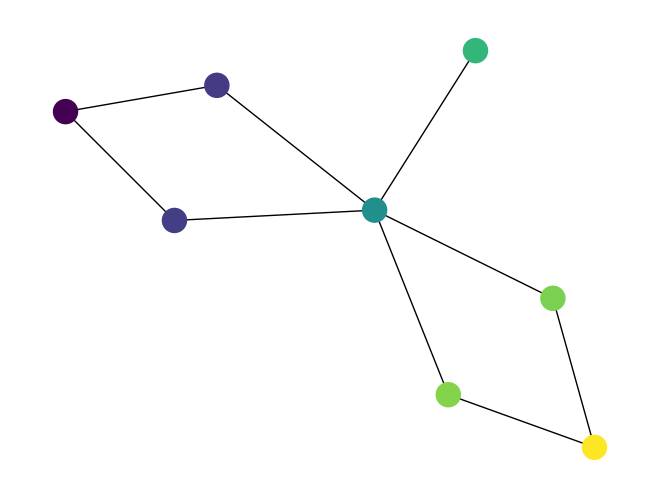

100%|██████████| 100/100 [00:03<00:00, 28.21it/s]


loss: -5.165761852165819
topo_loss: -6.4955429427036915
mode:
Indices of rows that are all zeros: (tensor([], dtype=torch.int64),)


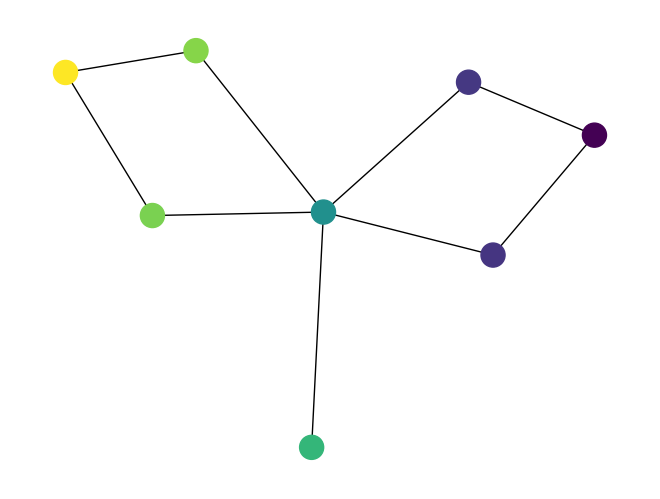

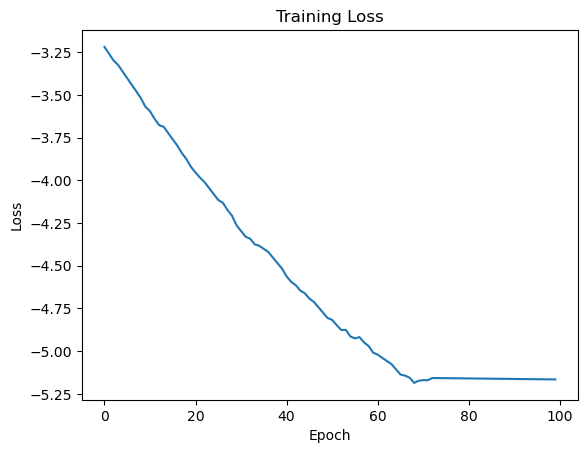

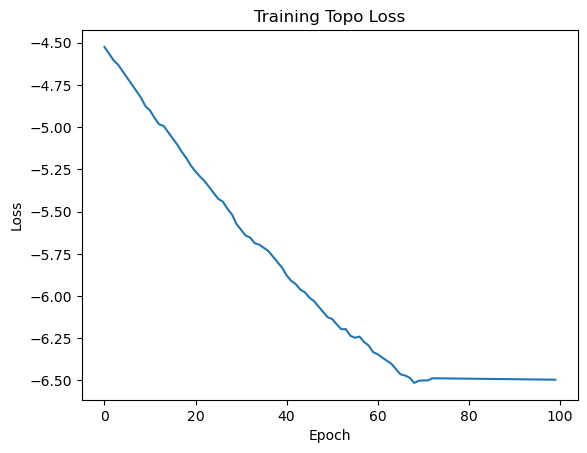

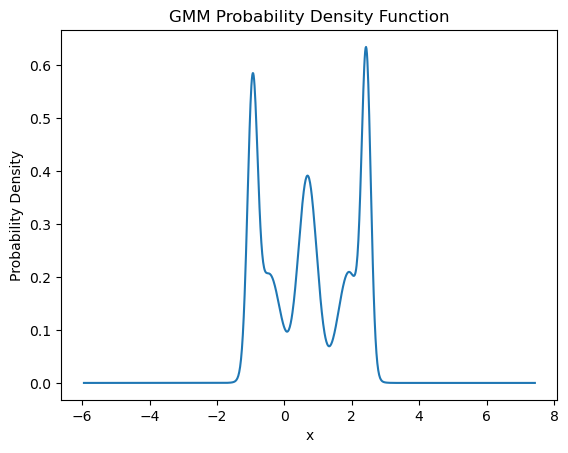

After:
mode:
Indices of rows that are all zeros: (tensor([], dtype=torch.int64),)


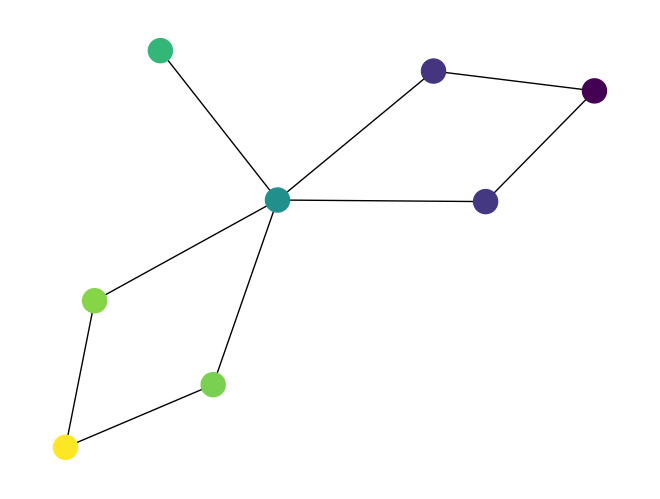

In [21]:
# data
csv_file = 'data/two_insert_noisy_cir.csv'
data = np.loadtxt(csv_file,delimiter=",")
data = torch.tensor(data)
projected_data = data[:,0]
projected_data = projected_data.view(len(data), 1)
n = 70 #70/100
# init
n_comp = 5
num_step = 100
l1 = 1
l2 = 1 
db = DBSCAN(eps=0.6,  min_samples=5)

# GMM initialization
gmm = GaussianMixture(n_components=n_comp, covariance_type='full', n_init = 10,
                      max_iter= 1000,tol=1e-6
                      ,random_state = 2)
gmm.fit(projected_data)
init_mean = torch.tensor(gmm.means_).view(-1)
init_var = torch.tensor(gmm.covariances_).view(-1)
init_weights = torch.tensor(gmm.weights_).view(-1)
m = Opt_GMM_Mapper(n_comp, means = init_mean, covariances=init_var, weights=init_weights)
init_scheme = m.forward(projected_data, data, db)

# mapper before optimization
print('Before:')
mapper = Soft_Mapper.GMM_Soft_Mapper(init_scheme, db, data = data, projected_data =projected_data,path='figures',name = '2cn',format = 'eps')
G_mode_before = mapper.mode(save_fig= False)
filtration_k = mapper.mode_filtration[0]
filtration_k = filtration_k[~torch.isnan(filtration_k)]
before_list = filtration_k.detach().numpy()

# define optimizer and scheduler
optimizer = optim.Adam(m.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=1)
scheduler = lr_scheduler.StepLR(optimizer, step_size=n, gamma=0.01)

# train
train = Trainer(m, db, num_step, optimizer, scheduler)
train.fit(data, projected_data, l1, l2)
train.analysis()

# mapper after optimization
print('After:')
after_mapper = Soft_Mapper.GMM_Soft_Mapper(train.scheme, db, data = data, projected_data =projected_data,path='figures',name = '2cn',format = 'eps')
G_mode_after = after_mapper.mode(save_fig= False)
filtration_k = after_mapper.mode_filtration[0]
filtration_k = filtration_k[~torch.isnan(filtration_k)]
after_list = filtration_k.detach().numpy()

clusters = train.mode_clusters
clusters = clusters.squeeze(dim = 0)
clusters = clusters[:, ~torch.all(clusters == 0, dim=0)]
from scripts.analysis_msbb import qurey_node_id
node_5 = qurey_node_id(clusters, 5)
node_0 = qurey_node_id(clusters, 0)

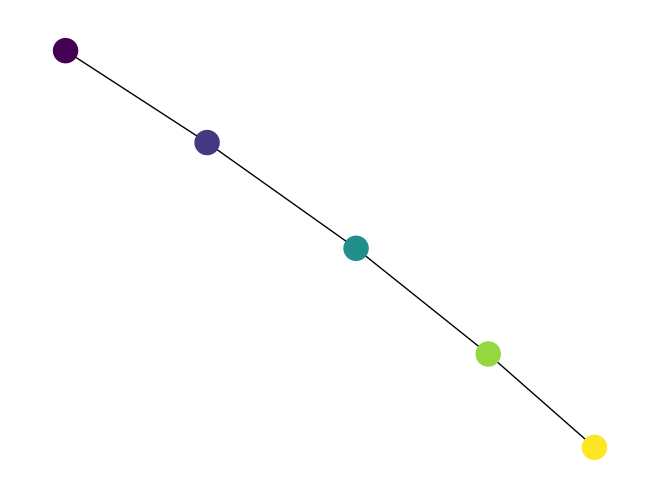

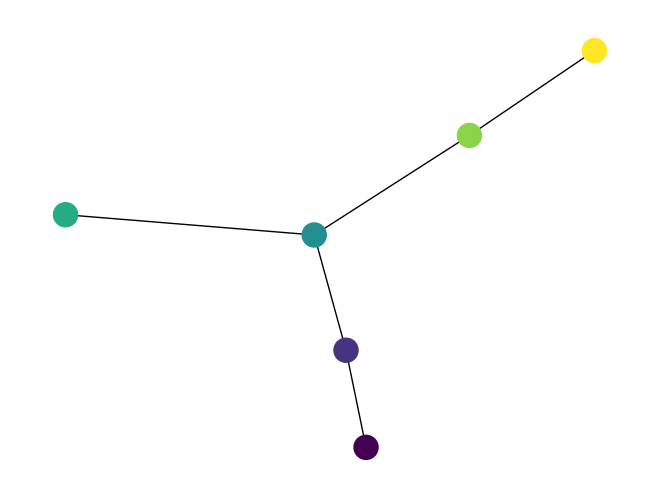

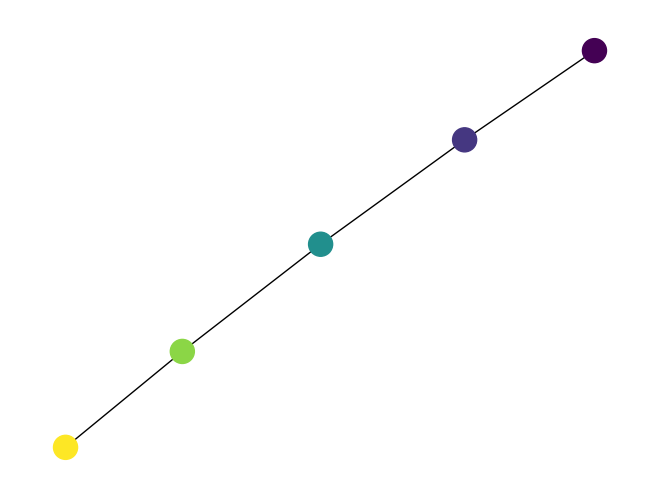

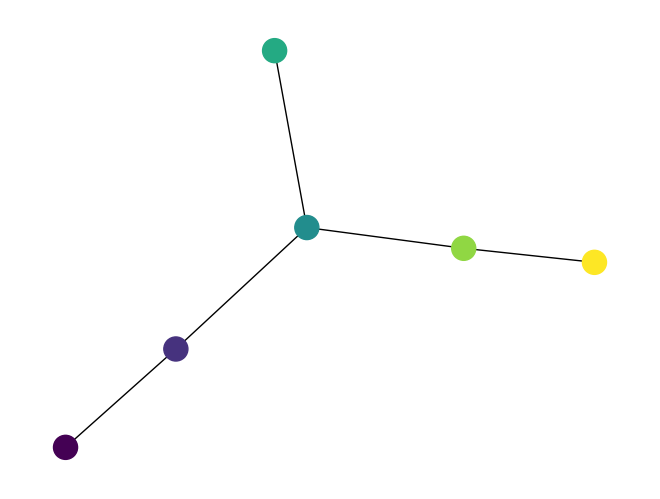

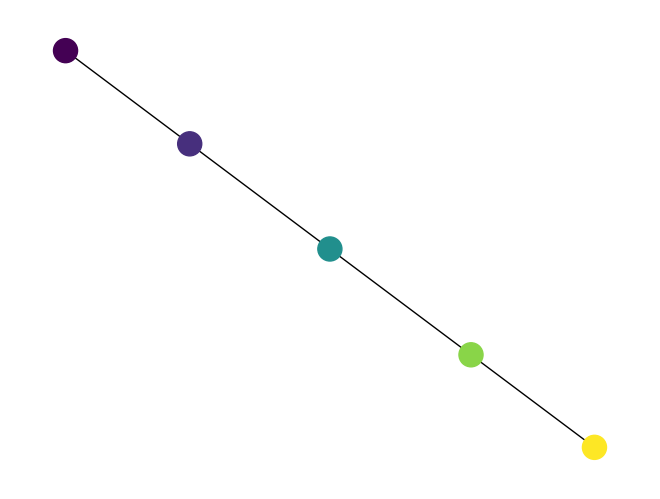

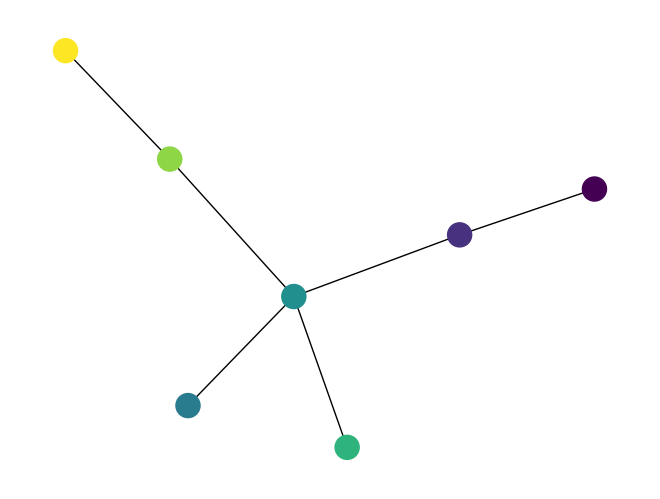

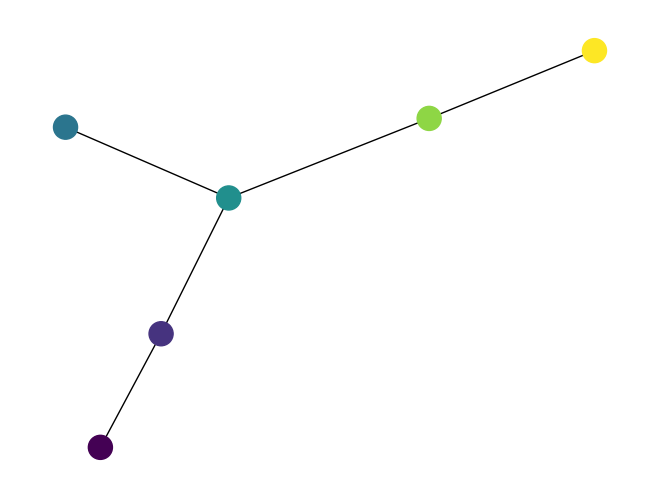

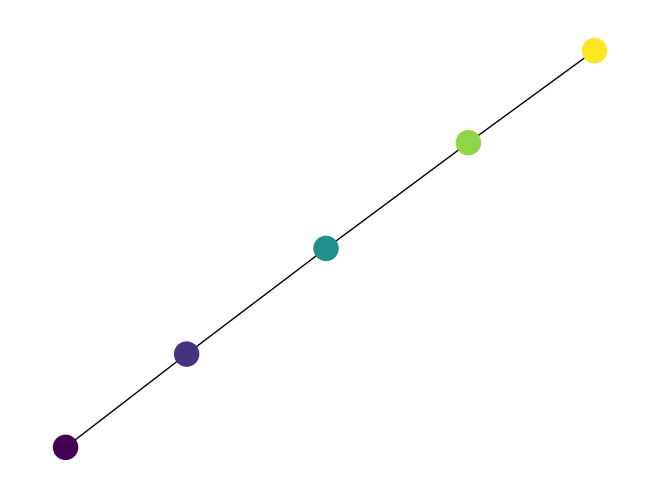

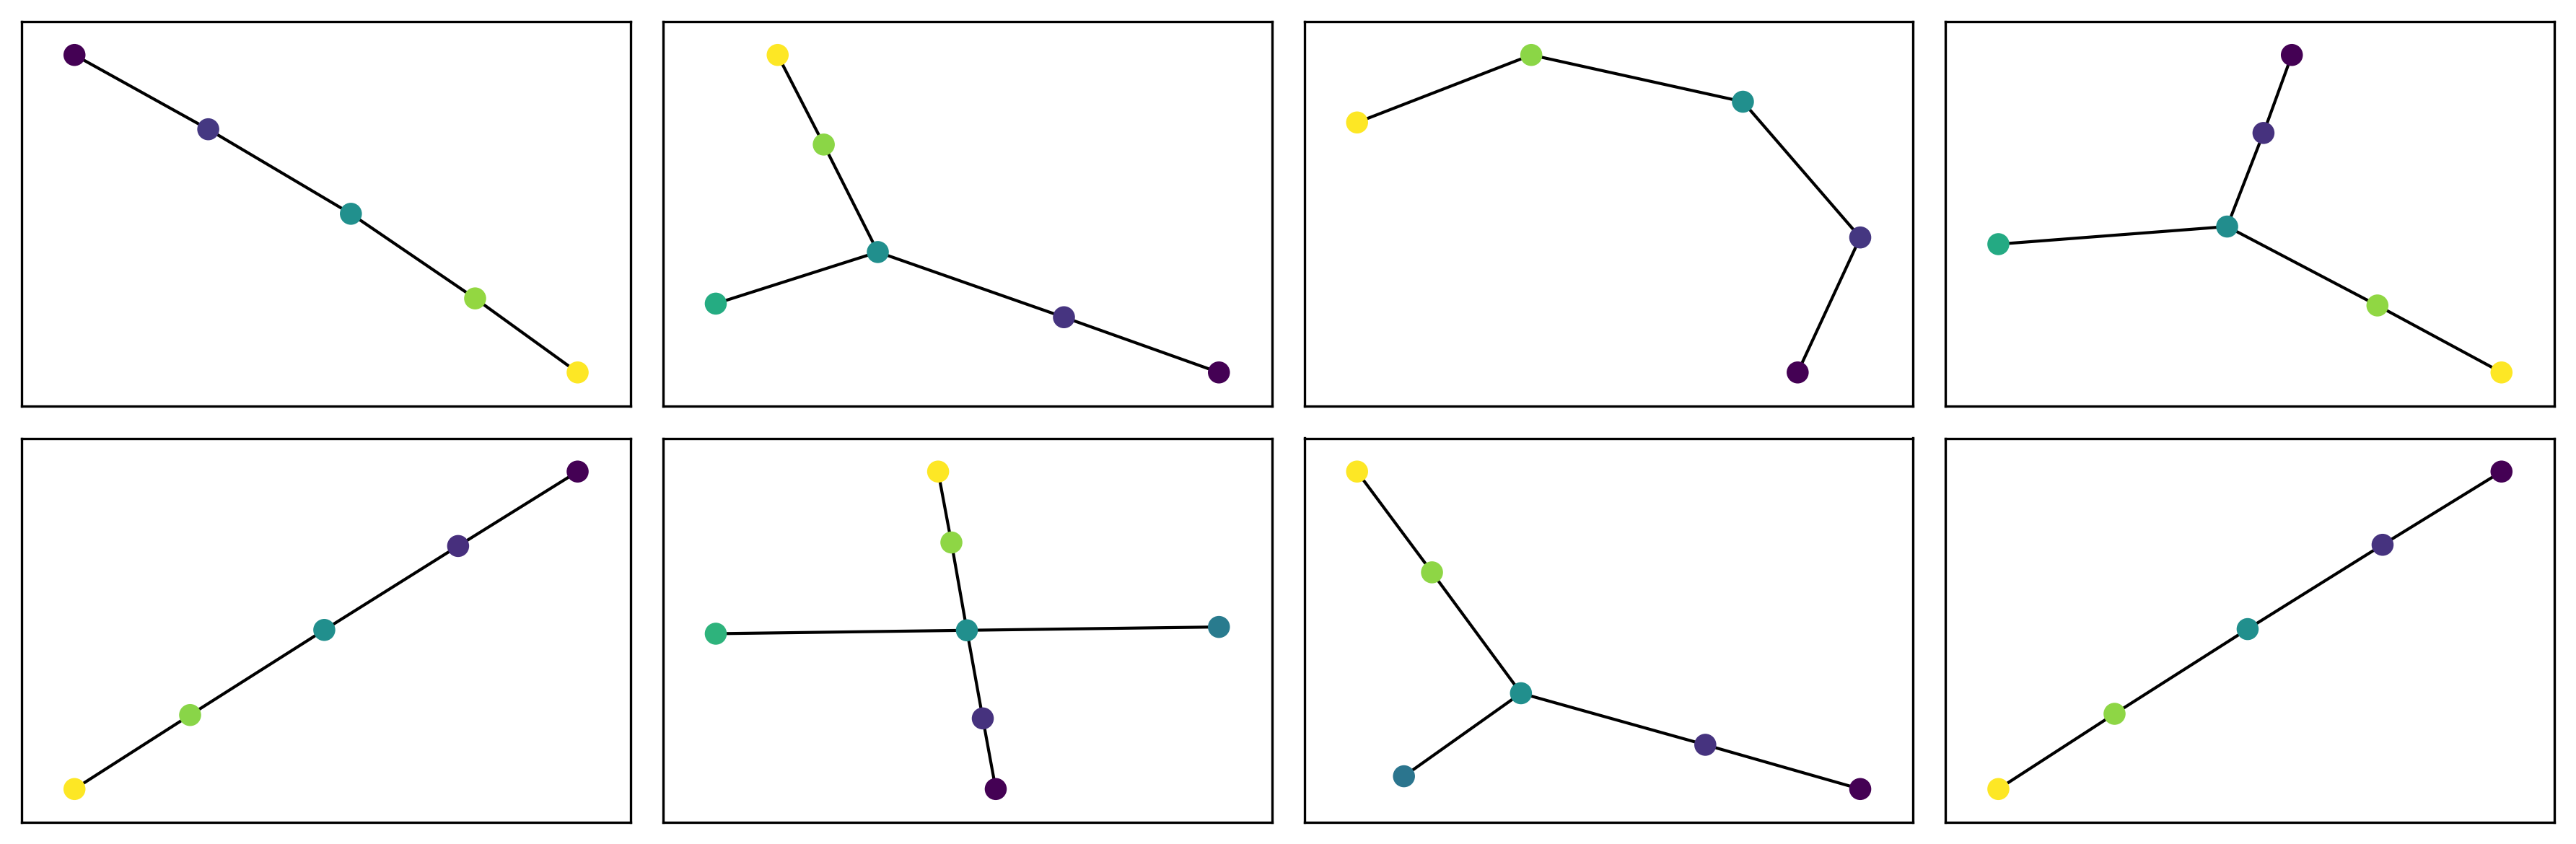

In [31]:
mapper = Soft_Mapper.GMM_Soft_Mapper(train.scheme, db, data = data, projected_data =projected_data
                                     ,path='figures',name = '2cn',format = 'eps')
G_list = mapper.sample(8,plot_num = None, save_fig = False)

plt.figure(figsize=(12, 4), dpi= 300)

for i, G in enumerate(G_list):
    ax = plt.subplot(2, 4, i+1)  
    pos = nx.spring_layout(G)  
    filtration_k = mapper.filtration[i]
    filtration_k = filtration_k[~torch.isnan(filtration_k)]

    nx.draw_networkx(G, pos, with_labels=False,node_color = filtration_k,node_size = 40)
    ax.set_xticks([])  
    ax.set_yticks([])  

plt.tight_layout()
plt.savefig('figures/2icn.eps', bbox_inches='tight')
plt.show()

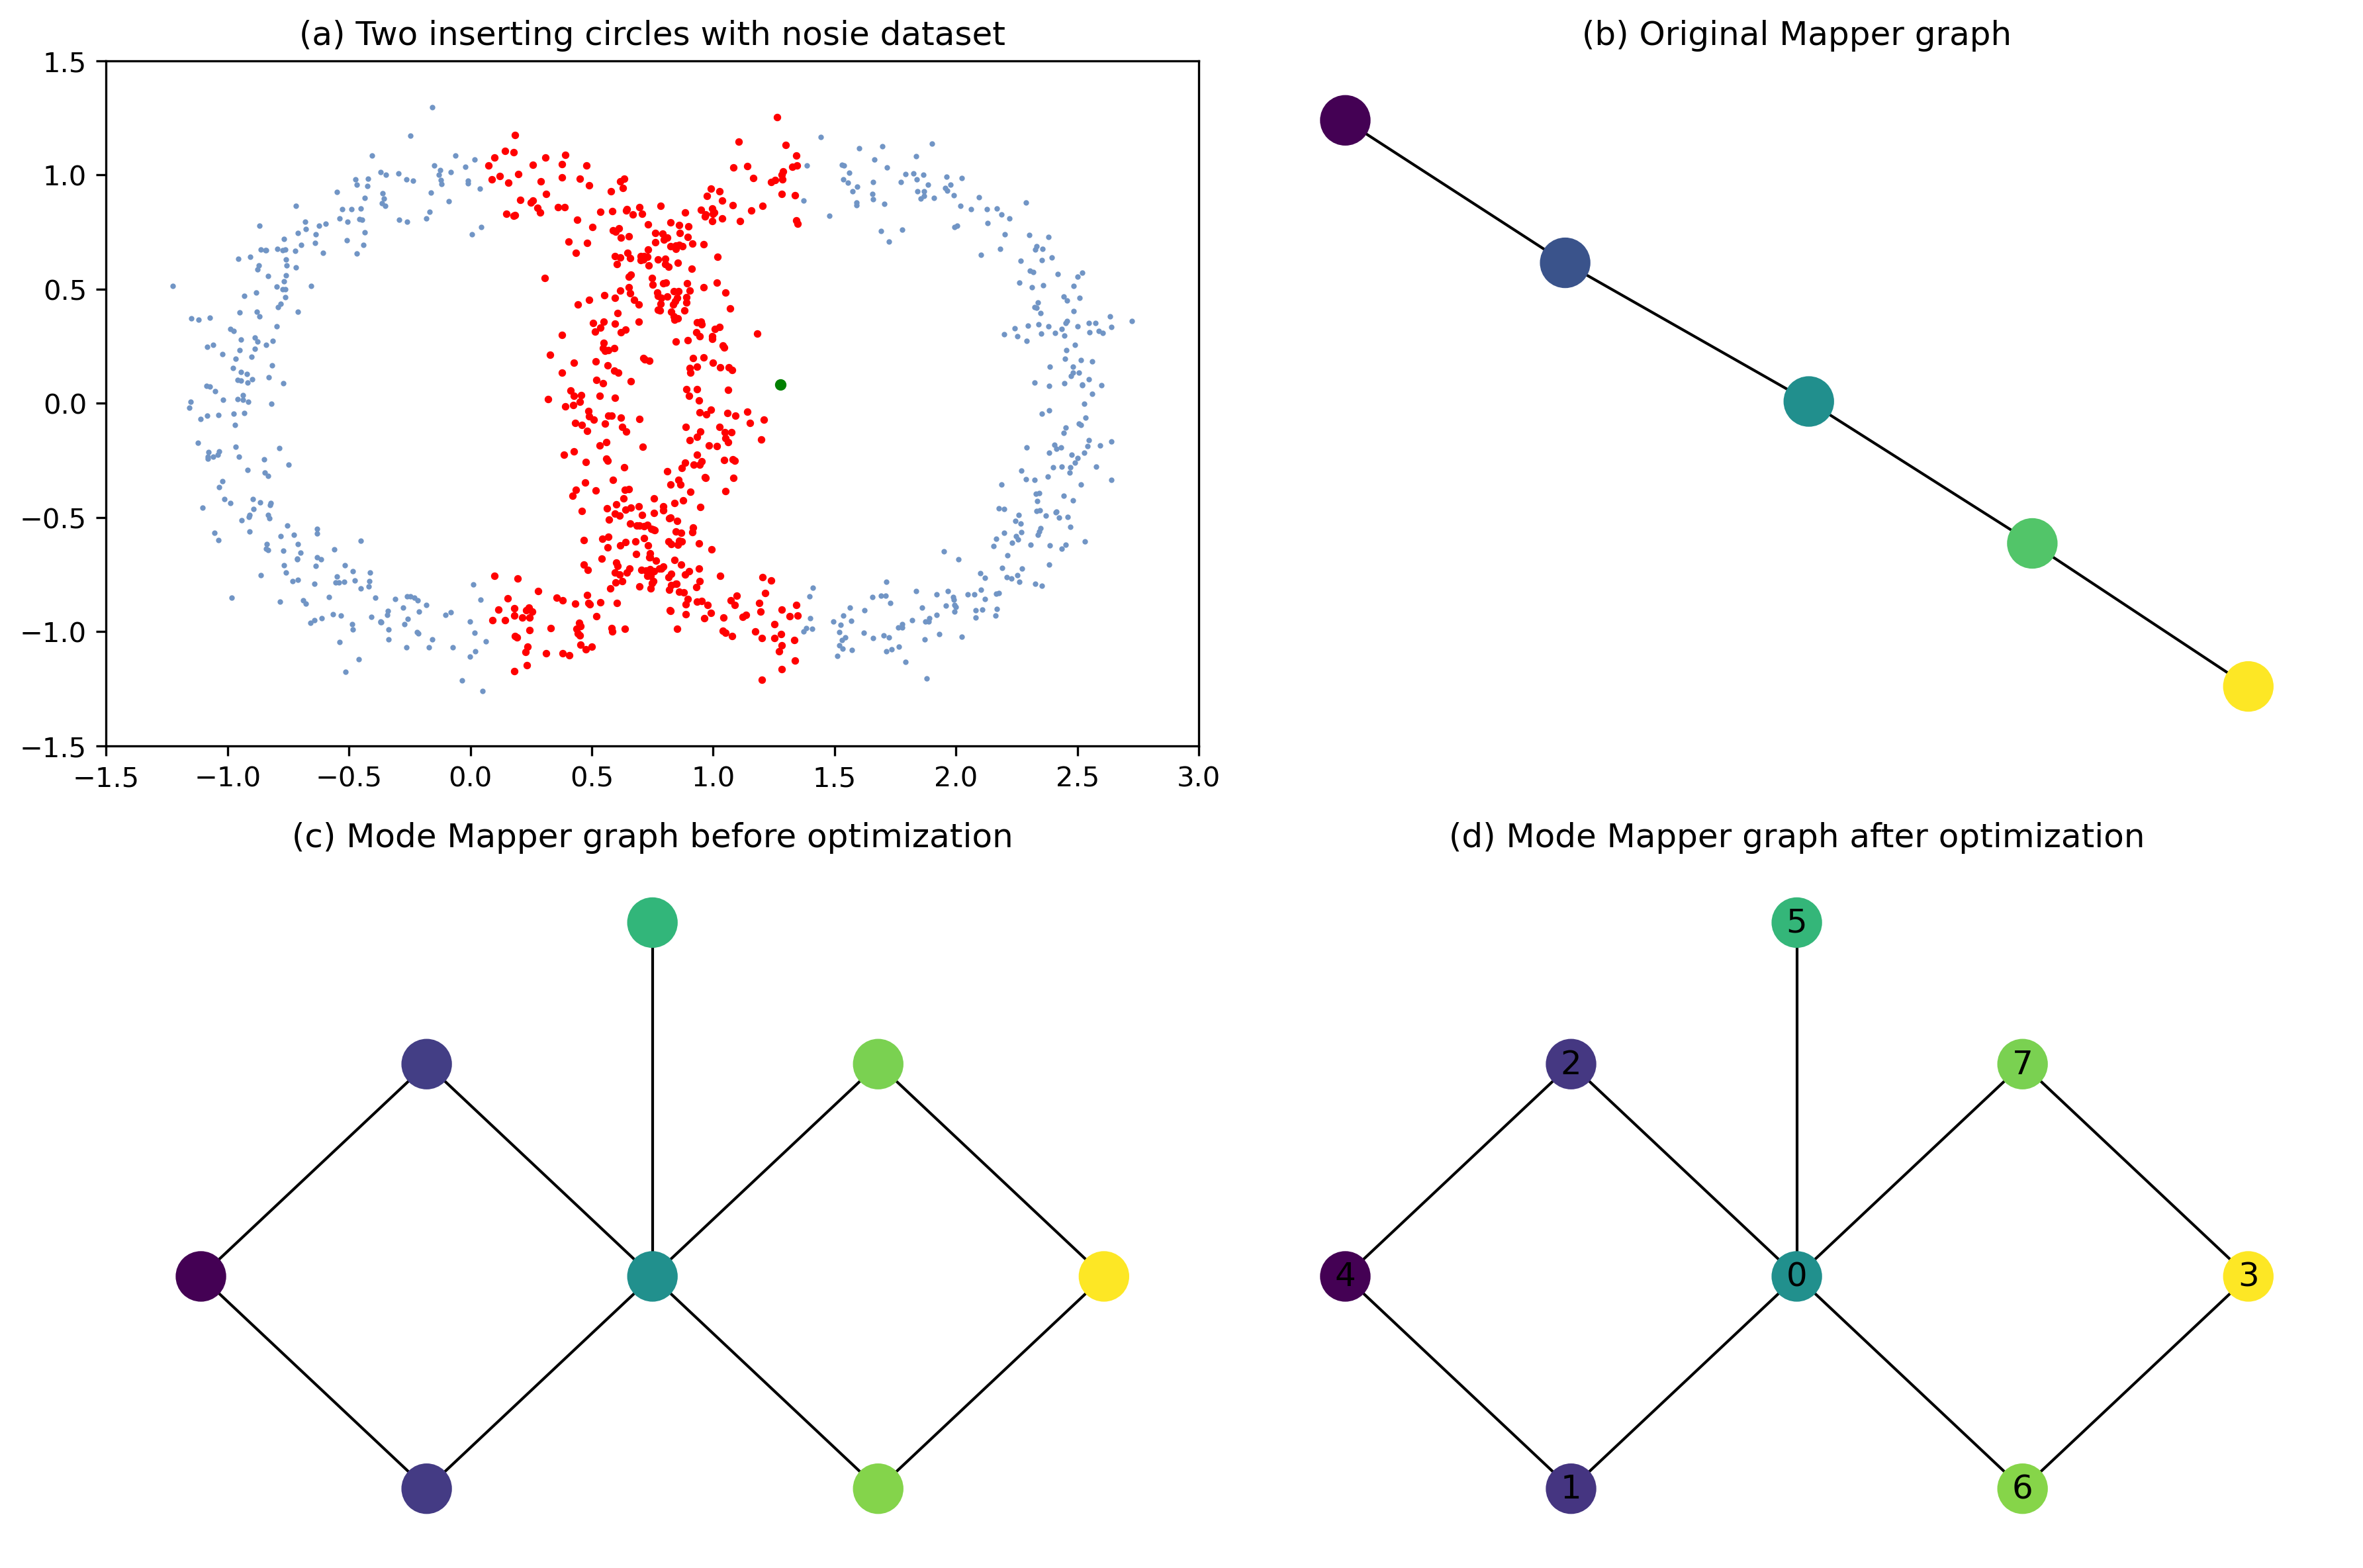

In [38]:
mapper = MapperComplex(
resolutions=n_comp,
gains=0.33,
clustering=db,
)
mapper.fit(data, filters=projected_data.numpy(),colors=projected_data.numpy())
G = mapper.get_networkx()

fig, axs = plt.subplots(2, 2)  
fig.set_size_inches(12, 8)  
fig.dpi = 300  

data = np.loadtxt("data/two_insert_noisy_cir.csv", delimiter=",")
axs[0, 0].scatter(data[:,0],data[:,1],s=1,c='#7195c5')
axs[0, 0].scatter(data[node_0,0],data[node_0,1],s=3,c='red')
axs[0, 0].scatter(data[node_5,0],data[node_5,1],s=10,c='green')
axs[0, 0].set_xlim((-1.5, 3))
axs[0, 0].set_ylim((-1.5, 1.5))

'''pos = {0: np.array([0., 0.]), 1: np.array([-0.3, 0.3]), 2: np.array([-0.3,  -0.3]), 
       3: np.array([-0.6,  0.]), 4: np.array([0.1,  0.0]), 5: np.array([ 0.4, 0.3]), 
       7: np.array([0.4, -0.3]), 8: np.array([ 0., 0.2]), 9: np.array([0.7, 0.]), 
       6: np.array([0.9, 0.])}

pos = {3: np.array([-0.6,  0.]), 0: np.array([0., 0.]), 4: np.array([0.6, 0.]), 
       1: np.array([0.3, 0.2]), 2: np.array([ 0.3, -0.2]), 5: np.array([-0.3, -0.2]), 
       6: np.array([-0.3,  0.2]), 7: np.array([-0.,  0.3])}

pos = {0: np.array([ -0.3, -0.2]), 1: np.array([ -0.3, 0.2]), 2: np.array([0.2,  0.]), 
       3: np.array([-0.04690658,  0.31]), 4: np.array([0.5,  0.2]), 5: np.array([0.5,  -0.2]), 
       6: np.array([1.,  0.]), 7: np.array([-0.8,  0.]), 8: np.array([0.8,  0.]), 
       9: np.array([-0.6,  0.]), 10: np.array([ 0., 0.])}'''

pos = {0: np.array([0., 0.]), 1: np.array([-0.3, -0.3]), 2: np.array([-0.3,  0.3]), 
       3: np.array([0.6, 0.]), 4: np.array([-0.6,  0.]), 5: np.array([0.,  0.5]), 
       6: np.array([ 0.3, -0.3]), 7: np.array([0.3, 0.3])}


nx.draw(G, pos = nx.kamada_kawai_layout(G), 
        node_color=[mapper.node_info_[v]["colors"][0] for v in G.nodes()], 
        ax=axs[0, 1])

# nx.kamada_kawai_layout(G_mode_before)
nx.draw(G_mode_before, pos = pos, 
        node_color=before_list,
        ax=axs[1, 0]) 

# nx.kamada_kawai_layout(G_mode_after)
nx.draw(G_mode_after, pos = pos, 
        node_color=after_list, with_labels = True,
        ax=axs[1, 1])  


axs[0, 0].set_title('(a) Two inserting circles with nosie dataset')
axs[0, 1].set_title('(b) Original Mapper graph')
axs[1, 0].set_title('(c) Mode Mapper graph before optimization')
axs[1, 1].set_title('(d) Mode Mapper graph after optimization')

plt.tight_layout()
plt.savefig("figures/2inc_all.eps")
plt.show()

mode:
Indices of rows that are all zeros: (tensor([], dtype=torch.int64),)


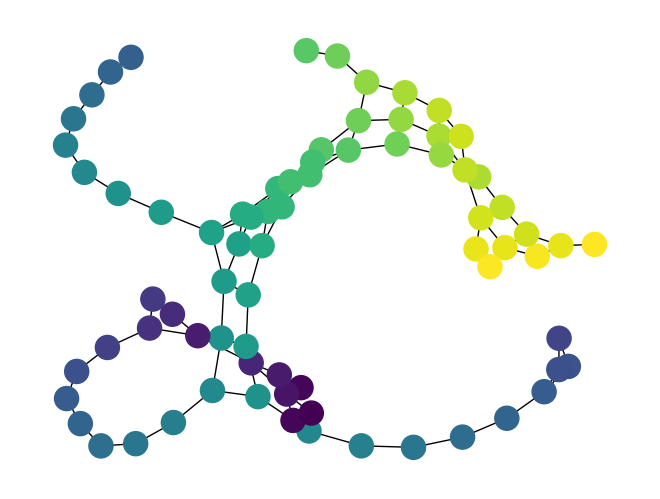

100%|██████████| 200/200 [01:25<00:00,  2.33it/s]


loss: -173.34747463389567
topo_loss: -175.2553813870317
mode:
Indices of rows that are all zeros: (tensor([], dtype=torch.int64),)


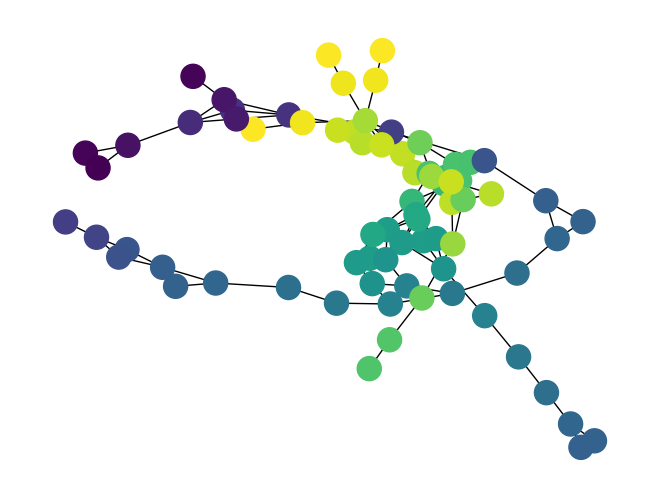

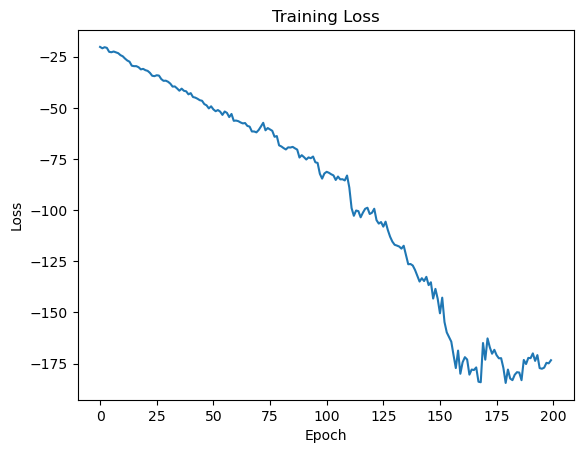

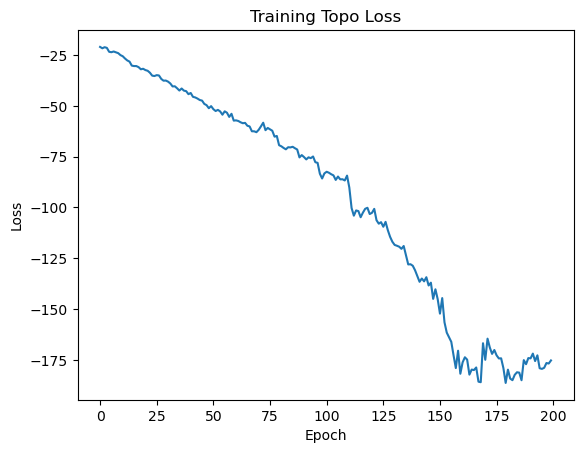

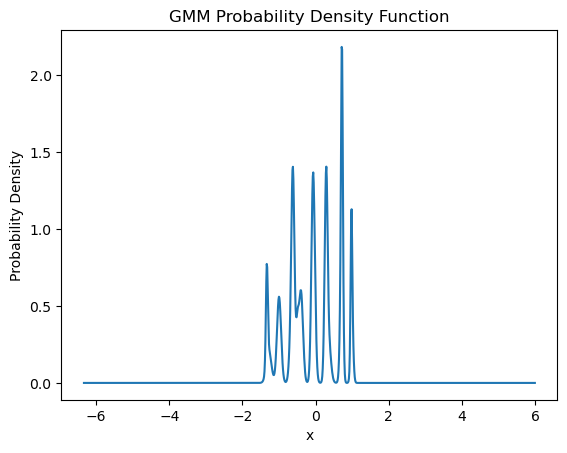

mode:
Indices of rows that are all zeros: (tensor([], dtype=torch.int64),)


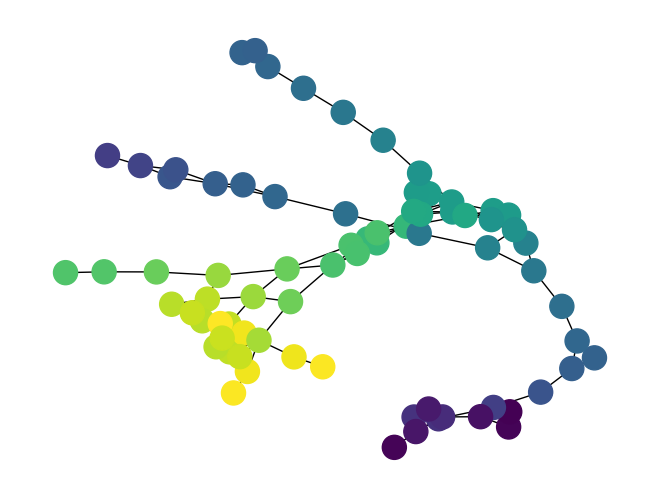

In [3]:
def off2numpy(shape_name):
    with open(shape_name, 'r') as S:
        S.readline()
        num_vertices, num_faces, _ = [int(n) for n in S.readline().split(' ')]
        info = S.readlines()
    vertices = np.array([[float(coord) for coord in l.split(' ')] for l in info[0:num_vertices]])
    faces    = np.array([[int(coord) for coord in l.split(' ')[1:]] for l in info[num_vertices:]])
    return vertices, faces
    
from sklearn.cluster import KMeans
# data
vertices, faces = off2numpy('data/human.off')

import numpy as np
from scipy.spatial.distance import pdist, squareform


distances = pdist(vertices, 'euclidean')
distance_matrix = squareform(distances)
distance_matrix = torch.Tensor(distance_matrix)


data = torch.tensor(vertices)
#projected_data = data[:,0]
projected_data = torch.sum(data, dim=1)
#projected_data = torch.mean(distance_matrix, dim = 1)
#weight = torch.tensor([[0.01794377],[1.8616167 ],[0.02403543]]).type_as(data)
#projected_data = torch.matmul(data,weight)

projected_data = projected_data.view(len(data), 1)

# init
n = 150 
n_comp = 25
num_step = 200
l1 = 1
l2 = 1 

# GMM initialization
gmm = GaussianMixture(n_components=n_comp, covariance_type='full', n_init = 10,
                      max_iter= 1000,tol=1e-6
                      ,random_state = 0)
gmm.fit(projected_data)
init_mean = torch.tensor(gmm.means_).view(-1)
init_var = torch.tensor(gmm.covariances_).view(-1)
init_weights = torch.tensor(gmm.weights_).view(-1)


db = DBSCAN(eps=0.2,  min_samples=3)
kmeans = KMeans(n_clusters=3,random_state=0)
cl = kmeans

m = Opt_GMM_Mapper(n_comp, means = init_mean, covariances=init_var, weights=init_weights)
init_scheme = m.forward(projected_data, data, cl)

# mapper before optimization
mapper = Soft_Mapper.GMM_Soft_Mapper(init_scheme, cl, data = data, projected_data =projected_data,path='figures',name = 'human',format = 'eps')
G_mode_before = mapper.mode(save_fig= False)
filtration_k = mapper.mode_filtration[0]
filtration_k = filtration_k[~torch.isnan(filtration_k)]
before_list = filtration_k.detach().numpy()

optimizer = optim.Adam(m.parameters(), lr=0.0005, betas=(0.9, 0.999), eps=1e-08, weight_decay=1)
scheduler = lr_scheduler.StepLR(optimizer, step_size=n, gamma=0.1)

# train
train = Trainer(m, cl, num_step, optimizer, scheduler)
train.fit(data, projected_data, l1, l2)
train.analysis()

# mapper after optimization
after_mapper = Soft_Mapper.GMM_Soft_Mapper(train.scheme, cl, data = data, projected_data =projected_data,path='figures',name = 'human',format = 'eps')
G_mode_after = after_mapper.mode(save_fig= False)
filtration_k = after_mapper.mode_filtration[0]
filtration_k = filtration_k[~torch.isnan(filtration_k)]
after_list = filtration_k.detach().numpy()

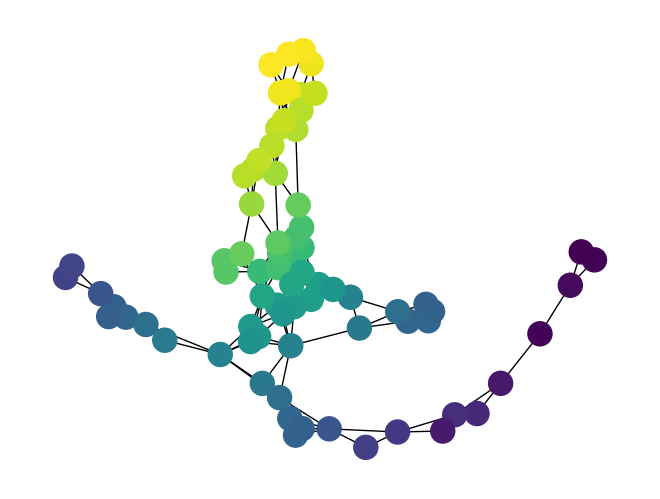

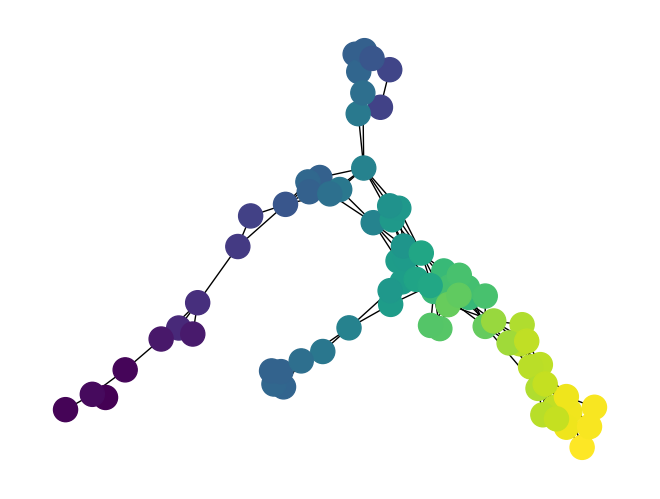

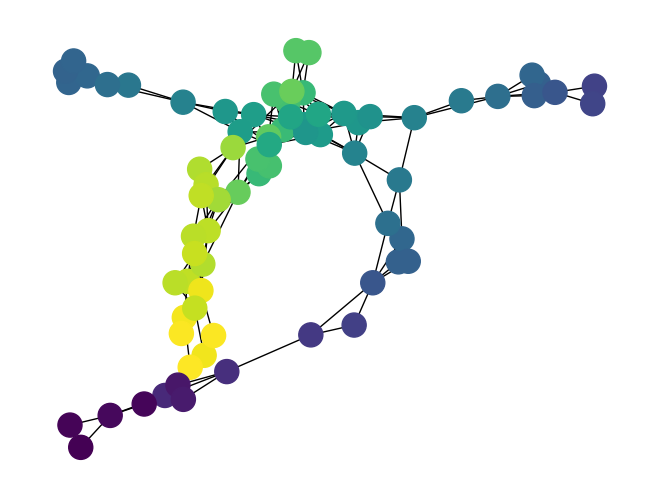

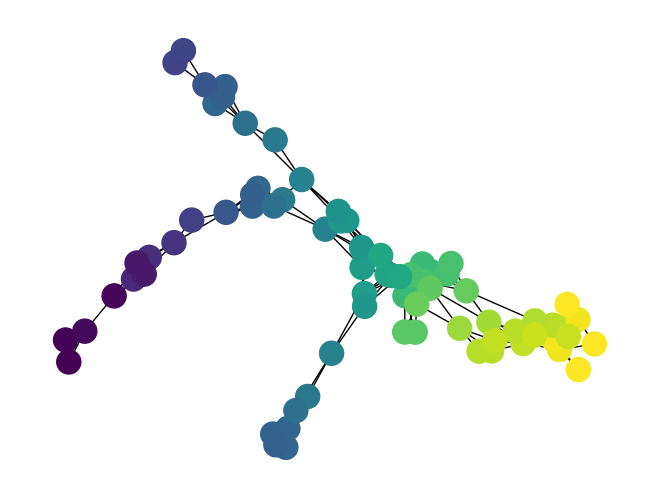

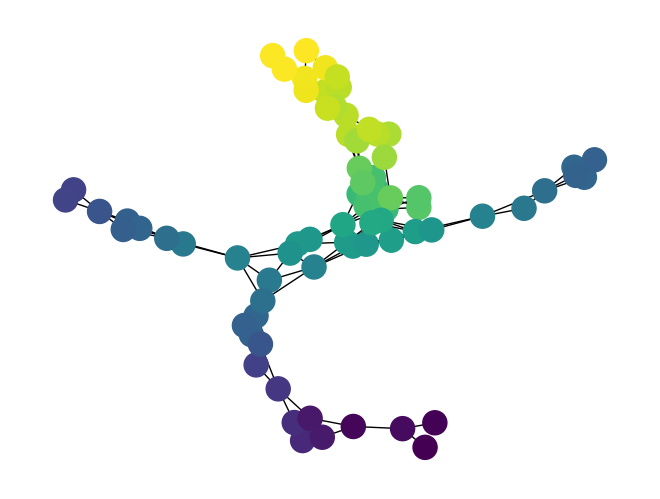

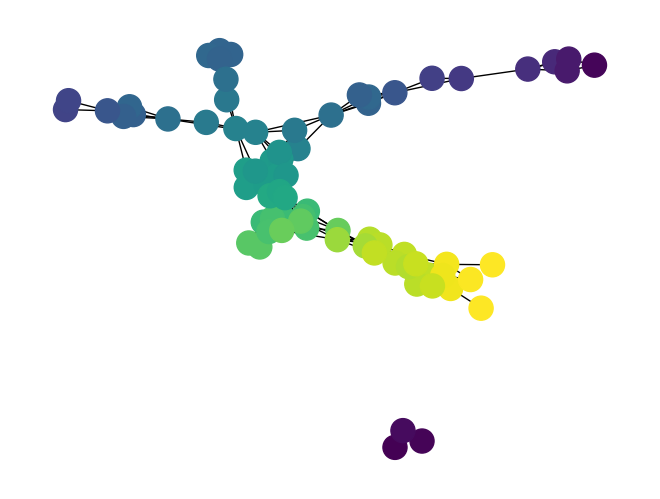

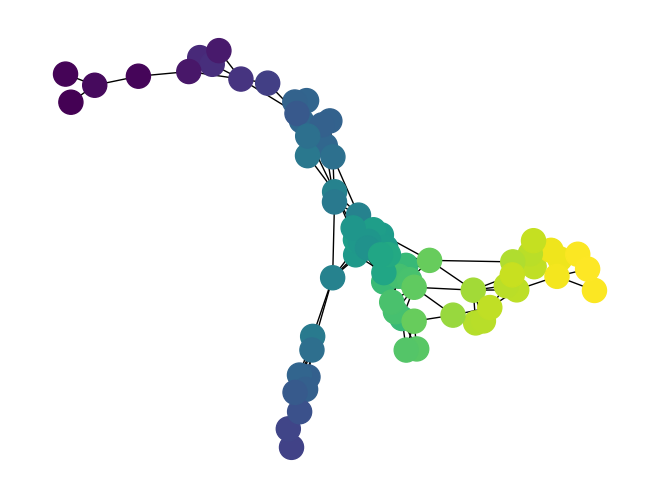

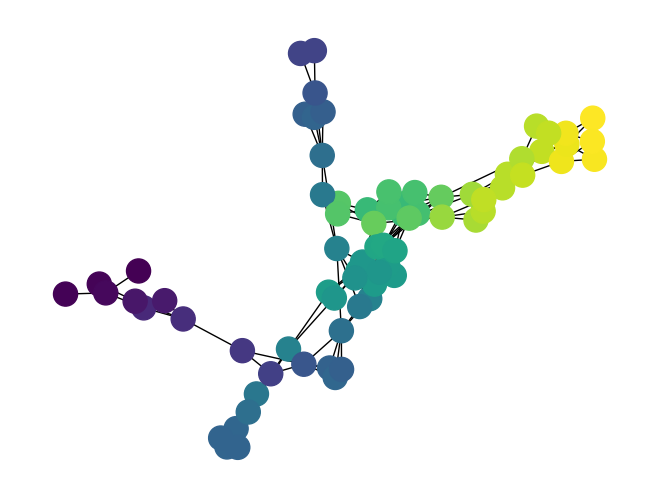

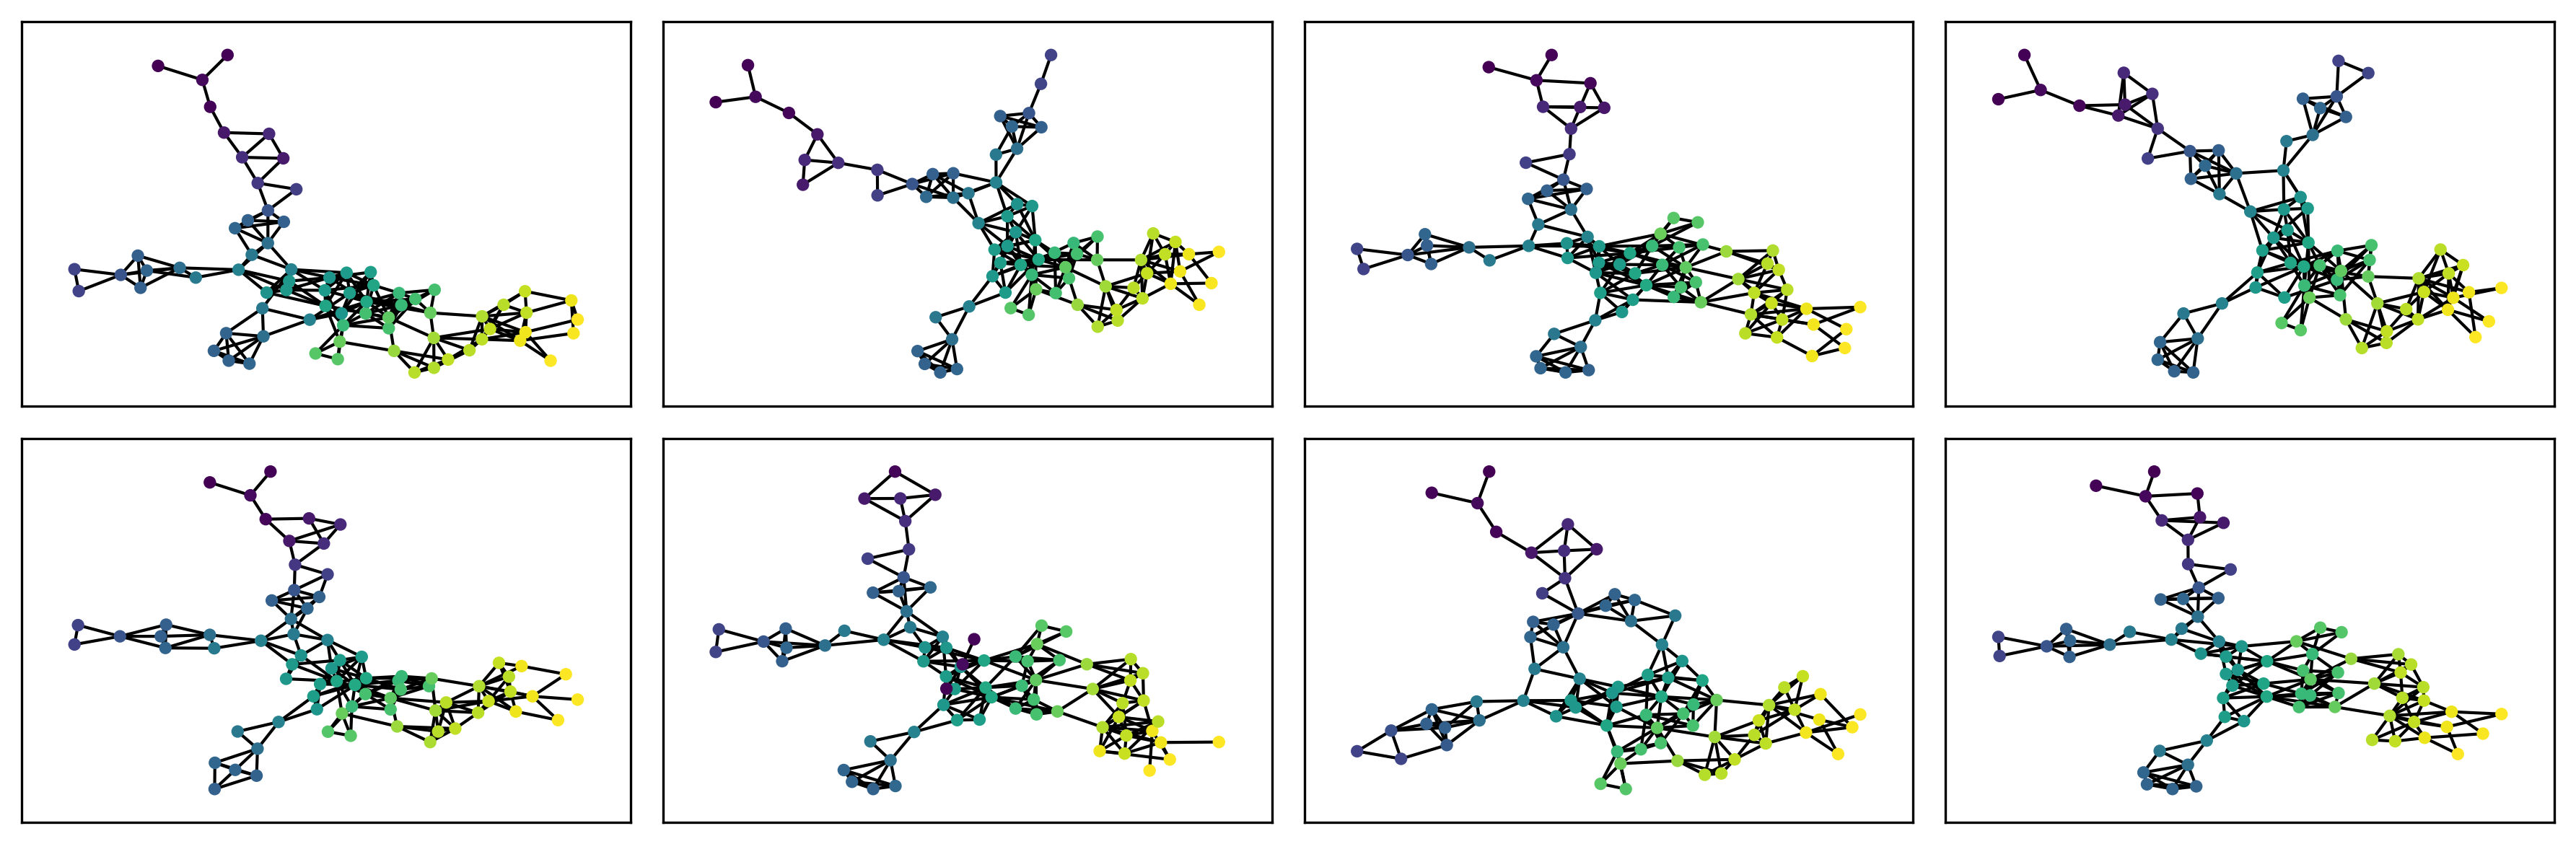

In [25]:
mapper = Soft_Mapper.GMM_Soft_Mapper(train.scheme, cl, data = data, projected_data =projected_data
                                     ,path='figures',name = 'human',format = 'eps')
G_list = mapper.sample(8,plot_num = None, save_fig = False)

plt.figure(figsize=(12, 4), dpi= 300)

for i, G in enumerate(G_list):
    ax = plt.subplot(2, 4, i+1)  
    pos = nx.kamada_kawai_layout(G)  
    filtration_k = mapper.filtration[i]
    filtration_k = filtration_k[~torch.isnan(filtration_k)]

    nx.draw_networkx(G, pos, with_labels=False,node_color = filtration_k,node_size = 10)
    ax.set_xticks([])  
    ax.set_yticks([])  

plt.tight_layout()
plt.savefig('figures/human.eps', bbox_inches='tight')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


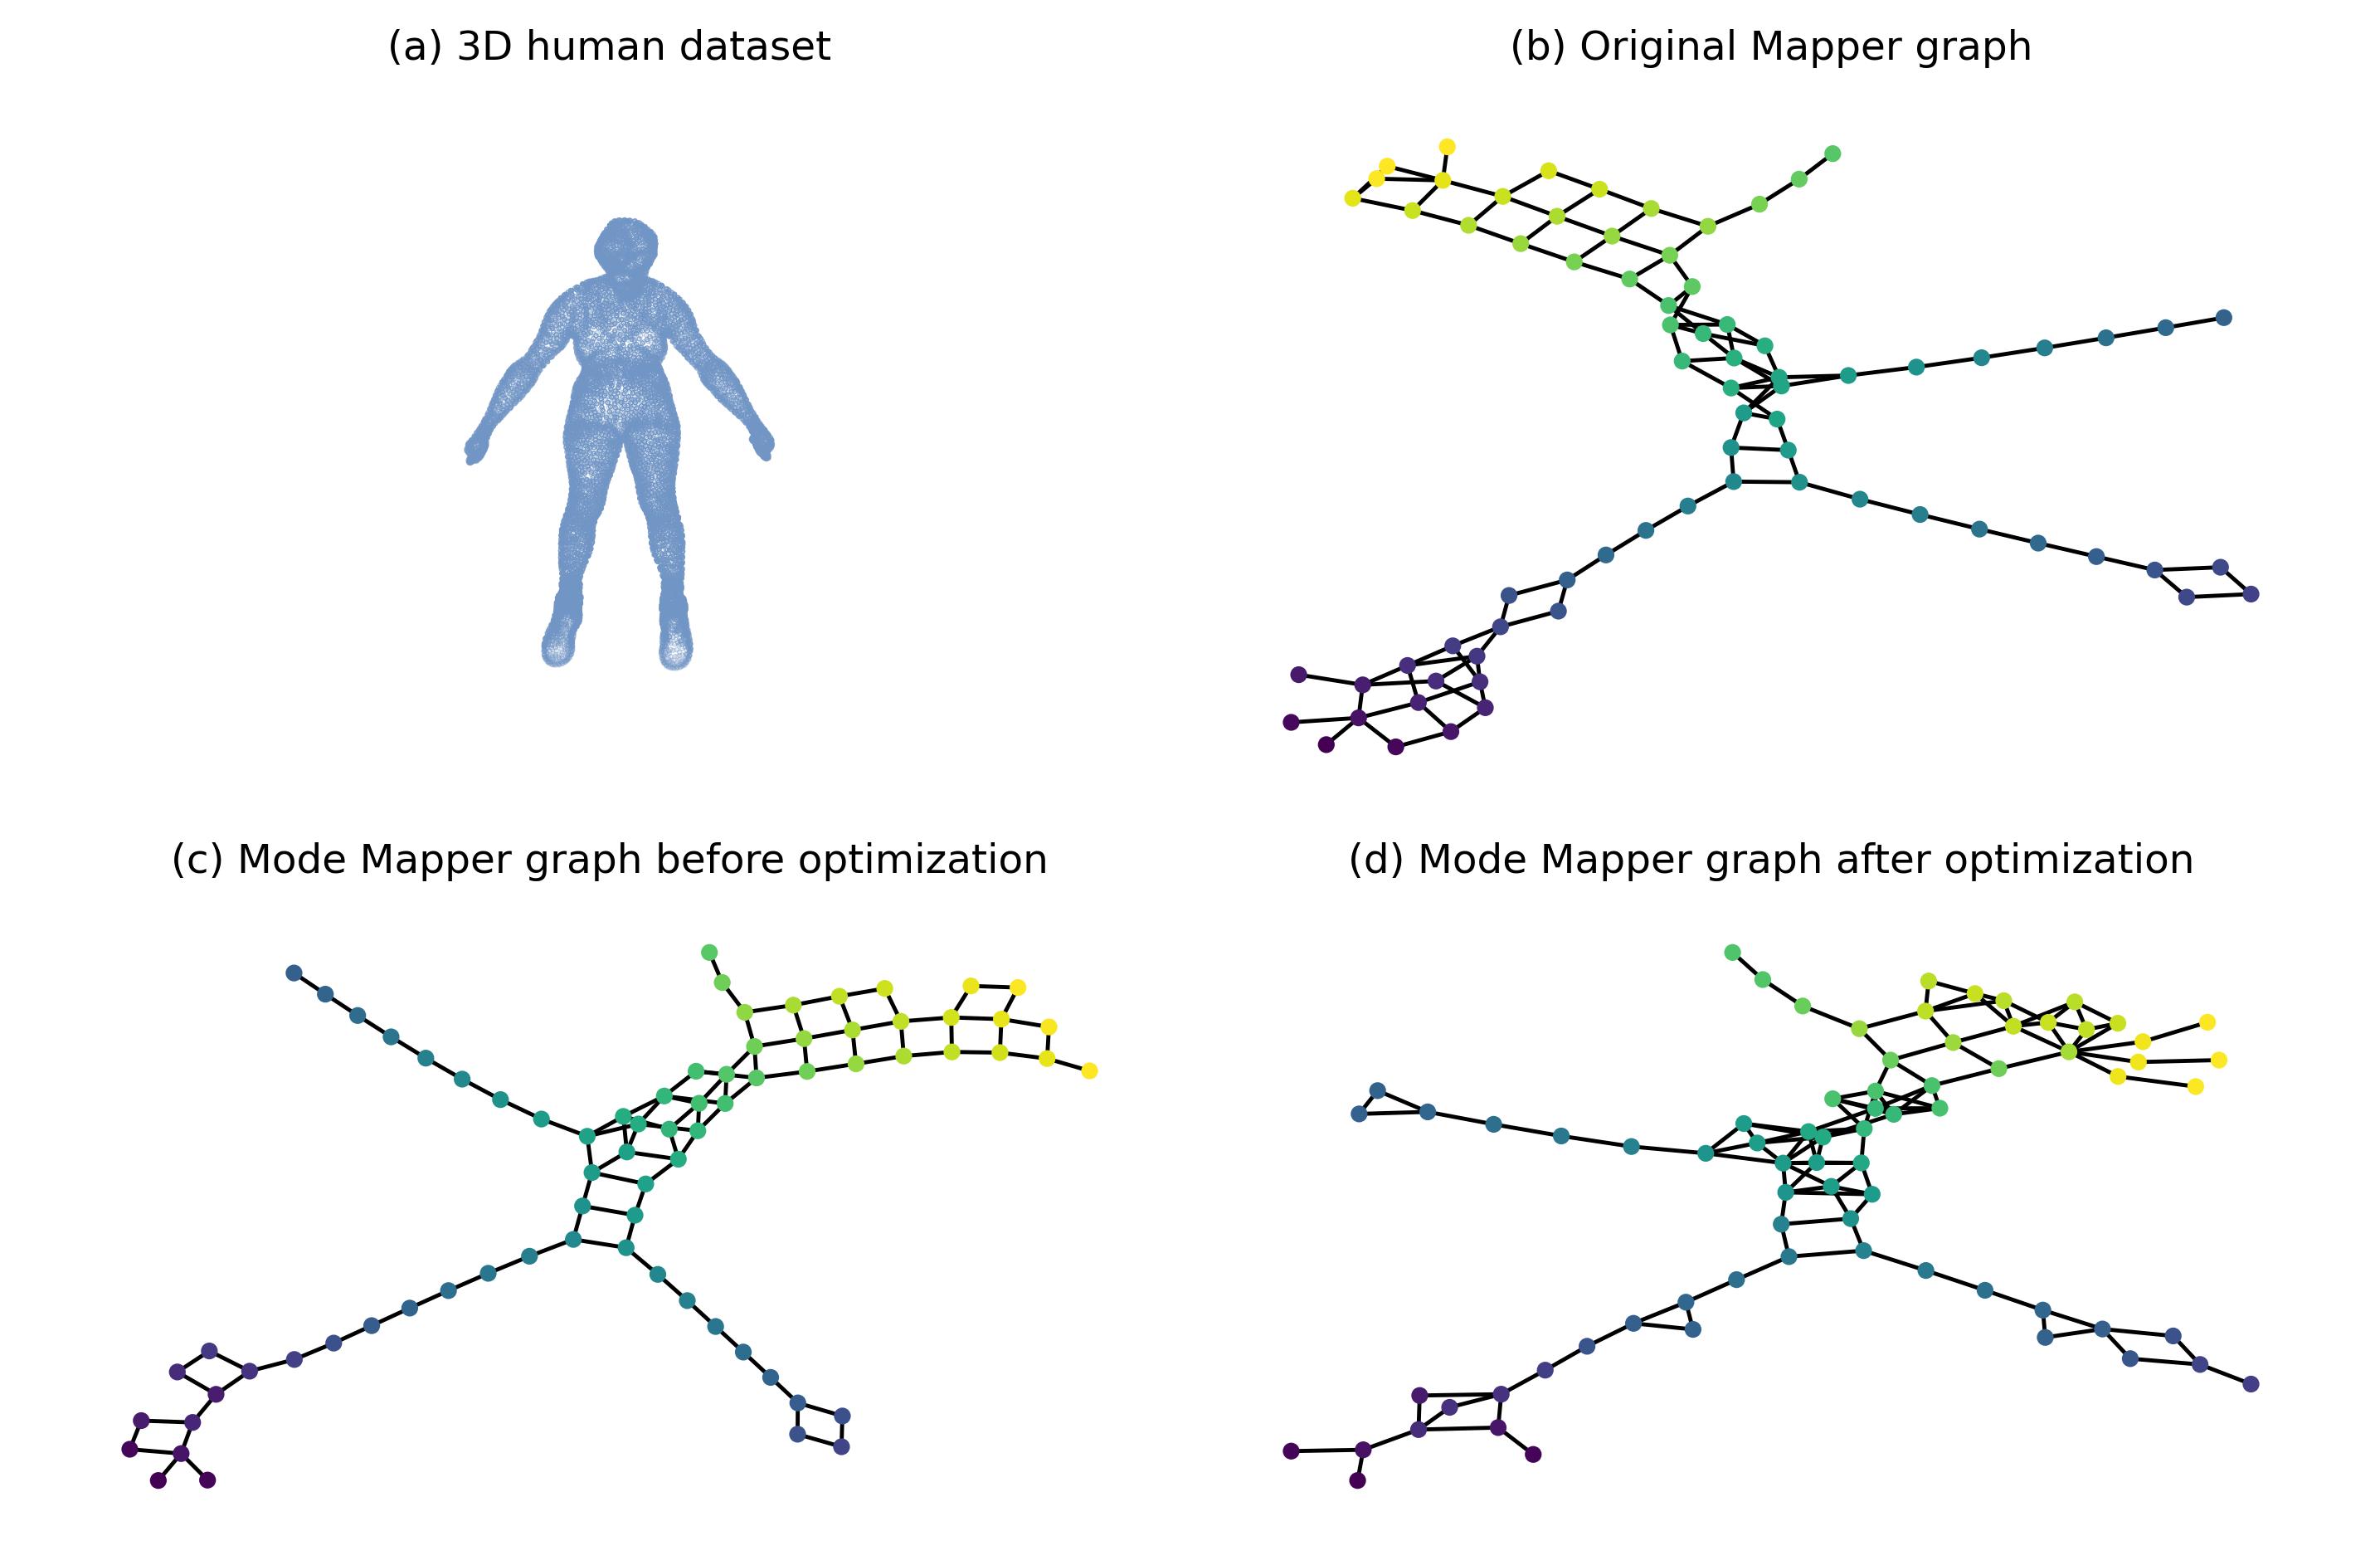

In [22]:
mapper = MapperComplex(
resolutions=n_comp,
gains=0.33,
clustering=cl,
)
mapper.fit(data, filters=projected_data.numpy(),colors=projected_data.numpy())
G = mapper.get_networkx()

fig = plt.figure(figsize=(8, 10),dpi=350) 


vertices, faces = off2numpy('data/human.off')

data = np.array(vertices)

ax = fig.add_axes([0, 0.75, 0.5, 0.25],projection='3d', proj_type='ortho')
ax.scatter3D(data[:,0], data[:,1], data[:,2], c='#7195c5',s=0.1)
ax.view_init(elev=0, azim=-10,roll=90)
ax.grid(None)
ax.axis('off')
ax.set_title("(a) 3D human dataset",fontsize=10)


theta = -45  # 旋转角度
R = np.array([[np.cos(np.radians(theta)), -np.sin(np.radians(theta))],
              [np.sin(np.radians(theta)), np.cos(np.radians(theta))]])
pos = nx.kamada_kawai_layout(G)
new_pos = {node: np.dot(pos[node], R) for node in pos}
ax2 = fig.add_axes([0.5, 0.75,0.5,0.25])
ax2.set_title('(b) Original Mapper graph',fontsize=10)
nx.draw(G, pos = new_pos, 
        node_color=[mapper.node_info_[v]["colors"][0] for v in G.nodes()], node_size = 10,
        ax=ax2)


theta = -90  # 旋转角度
R = np.array([[np.cos(np.radians(theta)), -np.sin(np.radians(theta))],
              [np.sin(np.radians(theta)), np.cos(np.radians(theta))]])
pos = nx.kamada_kawai_layout(G_mode_before)
new_pos = {node: np.dot(pos[node], R) for node in pos}
ax3 = fig.add_axes([0, 0.5, 0.5,0.22])
ax3.set_title('(c) Mode Mapper graph before optimization',fontsize=10)
nx.draw(G_mode_before, pos = new_pos, 
        node_color=before_list, node_size = 10,
        ax=ax3) 

ax4 = fig.add_axes([0.5, 0.5, 0.5 ,0.22])


theta = -90  # 旋转角度
R = np.array([[np.cos(np.radians(theta)), -np.sin(np.radians(theta))],
              [np.sin(np.radians(theta)), np.cos(np.radians(theta))]])
pos = nx.kamada_kawai_layout(G_mode_after)
new_pos = {node: np.dot(pos[node], R) for node in pos}
ax4.set_title('(d) Mode Mapper graph after optimization',fontsize=10)
nx.draw(G_mode_after, pos = new_pos, 
        node_color=after_list, node_size = 10,
        ax=ax4)  


plt.savefig("figures/human_all.eps", bbox_inches='tight')
plt.show()

In [117]:
vertices, faces = off2numpy('data/human.off')
shading = {"flat":True, # Flat or smooth shading of triangles
           "wireframe":False, "wire_width": 0.03, "wire_color": "black", # Wireframe rendering
           "width": 600, "height": 600, # Size of the viewer canvas
           "antialias": True, # Antialising, might not work on all GPUs
           "scale": 2.0, # Scaling of the model
           "side": "DoubleSide", # FrontSide, BackSide or DoubleSide rendering of the triangles
           "colormap": "viridis", "normalize": [None, None], # Colormap and normalization for colors
           "background": "#ffffff", # Background color of the canvas
           "line_width": 1.0, "line_color": "black", # Line properties of overlay lines
           "bbox": False, # Enable plotting of bounding box
           "point_color": "red", "point_size": 0.1 # Point properties of overlay points
          }

p = mp.plot(vertices, shading=shading, return_plot=True)
p.save("test.png")

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(-0.035629…

Plot saved to file test.png.html.
